# 요약

In [2]:
# Colab 환경용 한국어 텍스트 요약 모델 비교 평가 시스템
# KoBART vs ko-t5 성능 비교 및 종합 평가

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 필요한 라이브러리 설치 (Colab에서 실행)
import subprocess
import sys

def install_requirements():
    """필요한 패키지 설치"""
    packages = [
        'transformers',
        #'datasets',
        'rouge-score',
        'bert-score',
        'sentence-transformers',
        'scipy',
        'plotly'
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} 설치 완료")
        except:
            print(f"✗ {package} 설치 실패")

# 설치 실행
print("필요한 패키지 설치 중...")
install_requirements()

필요한 패키지 설치 중...
✓ transformers 설치 완료
✓ rouge-score 설치 완료
✓ bert-score 설치 완료
✓ sentence-transformers 설치 완료
✓ scipy 설치 완료
✓ plotly 설치 완료


In [ ]:
# 라이브러리 임포트
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    PreTrainedTokenizerFast, BartForConditionalGeneration
)
from datasets import load_dataset
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer
from scipy import stats
from tqdm import tqdm
import re
import random
from collections import Counter

class TextSummarizationEvaluator:
    """텍스트 요약 모델 비교 평가 클래스"""

    def __init__(self, num_samples=100, random_seed=42):
        self.num_samples = num_samples
        self.random_seed = random_seed
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # 결과 저장용
        self.results = {}
        self.predictions = {}
        self.references = []

        # 평가 지표 초기화
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], use_stemmer=False
        )

        print(f"🚀 평가 시스템 초기화 완료 (Device: {self.device})")

    def load_models(self):
        """KoBART와 ko-t5 모델 로드"""
        print("\n📥 모델 로딩 중...")

        # KoBART 모델 로드
        print("  - KoBART 로딩...")
        self.kobart_tokenizer = PreTrainedTokenizerFast.from_pretrained(
            'digit82/kobart-summarization'
        )
        self.kobart_model = BartForConditionalGeneration.from_pretrained(
            'digit82/kobart-summarization'
        ).to(self.device)

        # ko-t5 모델 로드
        print("  - ko-t5 로딩...")
        self.kot5_tokenizer = AutoTokenizer.from_pretrained(
            'lcw99/t5-base-korean-text-summary'
        )
        self.kot5_model = AutoModelForSeq2SeqLM.from_pretrained(
            'lcw99/t5-base-korean-text-summary'
        ).to(self.device)

        # Sentence-BERT 모델 로드 (의미적 유사성용)
        print("  - Sentence-BERT 로딩...")
        self.sbert_model = SentenceTransformer('klue/bert-base')

        print("✅ 모든 모델 로딩 완료!")

    def 
    
    
    (self):
        """데이터셋 로드 및 샘플링"""
        print(f"\n📊 데이터셋 로딩 중...")

        dataset = load_dataset("Laplace04/KoreanSummarizeAiHub")
        test_data = dataset['test']

        # 랜덤 시드 설정
        random.seed(self.random_seed)
        np.random.seed(self.random_seed)

        # 샘플링
        if len(test_data) > self.num_samples:
            indices = random.sample(range(len(test_data)), self.num_samples)
            self.test_samples = [test_data[i] for i in indices]
        else:
            self.test_samples = list(test_data)

        print(f"✅ {len(self.test_samples)}개 샘플 준비 완료")

    def generate_summary(self, text, model, tokenizer, model_name):
        """단일 텍스트 요약 생성"""
        try:
            # 공통 파라미터
            max_input_length = 1024
            max_output_length = 150
            min_output_length = 80

            # 입력 토크나이징
            if model_name == "ko-t5":
                # T5는 prefix가 필요할 수 있음
                input_text = f"summarize: {text}"
            else:
                input_text = text

            input_ids = tokenizer.encode(
                input_text,
                return_tensors="pt",
                truncation=True,
                max_length=max_input_length
            ).to(self.device)

            # 생성 파라미터 (모델별 조정)
            generation_kwargs = {
                'num_beams': 6,
                'max_length': max_output_length,
                'min_length': min_output_length,
                'length_penalty': 0.8,
                'early_stopping': True,
                'no_repeat_ngram_size': 4
            }

            # KoBART만 repetition_penalty 지원
            if model_name == "kobart":
                generation_kwargs['repetition_penalty'] = 3.0

            # 요약 생성
            with torch.no_grad():
                summary_ids = model.generate(input_ids, **generation_kwargs)

            # 디코딩
            summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            # T5의 경우 입력 prefix 제거
            if model_name == "ko-t5" and summary.startswith("summarize:"):
                summary = summary.replace("summarize:", "").strip()

            return summary

        except Exception as e:
            print(f"⚠️ 요약 생성 오류 ({model_name}): {e}")
            return ""

    def evaluate_models(self):
        """두 모델로 요약 생성 및 평가"""
        print(f"\n🔄 모델 평가 시작 ({self.num_samples}개 샘플)...")

        kobart_predictions = []
        kot5_predictions = []
        references = []

        # 배치 처리를 위한 진행바
        for i, sample in enumerate(tqdm(self.test_samples, desc="요약 생성")):
            try:
                passage = sample['passage']
                reference = sample['summary']

                # KoBART 요약
                kobart_pred = self.generate_summary(
                    passage, self.kobart_model, self.kobart_tokenizer, "kobart"
                )

                # ko-t5 요약
                kot5_pred = self.generate_summary(
                    passage, self.kot5_model, self.kot5_tokenizer, "ko-t5"
                )

                kobart_predictions.append(kobart_pred)
                kot5_predictions.append(kot5_pred)
                references.append(reference)

                # 메모리 정리 (Colab 환경 고려)
                if i % 20 == 0:
                    torch.cuda.empty_cache()

            except Exception as e:
                print(f"⚠️ 샘플 {i} 처리 오류: {e}")
                continue

        # 결과 저장
        self.predictions['kobart'] = kobart_predictions
        self.predictions['kot5'] = kot5_predictions
        self.references = references

        print(f"✅ 요약 생성 완료! (KoBART: {len(kobart_predictions)}, ko-t5: {len(kot5_predictions)})")

    def calculate_rouge_scores(self, predictions, references):
        """ROUGE 점수 계산"""
        rouge1_scores = []
        rouge2_scores = []
        rougeL_scores = []

        for pred, ref in zip(predictions, references):
            pred_clean = re.sub(r'\s+', ' ', pred.strip())
            ref_clean = re.sub(r'\s+', ' ', ref.strip())

            scores = self.rouge_scorer.score(ref_clean, pred_clean)
            rouge1_scores.append(scores['rouge1'].fmeasure)
            rouge2_scores.append(scores['rouge2'].fmeasure)
            rougeL_scores.append(scores['rougeL'].fmeasure)

        return {
            'rouge1': rouge1_scores,
            'rouge2': rouge2_scores,
            'rougeL': rougeL_scores
        }

    def calculate_bleu_scores(self, predictions, references):
        """BLEU 점수 계산"""
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

        # NLTK 다운로드
        try:
            import nltk
            nltk.download('punkt', quiet=True)
        except:
            pass

        bleu_scores = []
        smoothie = SmoothingFunction().method4

        for pred, ref in zip(predictions, references):
            # 한국어는 공백 기준으로 토크나이징
            pred_tokens = pred.split()
            ref_tokens = [ref.split()]  # BLEU는 reference가 리스트의 리스트

            try:
                bleu = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)
                bleu_scores.append(bleu)
            except:
                bleu_scores.append(0.0)

        return bleu_scores

    def calculate_bert_scores(self, predictions, references):
        """BERTScore 계산"""
        try:
            P, R, F1 = bert_score(predictions, references, lang='ko', verbose=False)
            return F1.numpy().tolist()
        except Exception as e:
            print(f"⚠️ BERTScore 계산 오류: {e}")
            return [0.0] * len(predictions)

    def calculate_semantic_similarity(self, predictions, references):
        """의미적 유사성 계산 (코사인 유사도)"""
        try:
            pred_embeddings = self.sbert_model.encode(predictions)
            ref_embeddings = self.sbert_model.encode(references)

            # 코사인 유사도 계산
            similarities = []
            for pred_emb, ref_emb in zip(pred_embeddings, ref_embeddings):
                similarity = np.dot(pred_emb, ref_emb) / (
                    np.linalg.norm(pred_emb) * np.linalg.norm(ref_emb)
                )
                similarities.append(similarity)

            return similarities
        except Exception as e:
            print(f"⚠️ 의미적 유사성 계산 오류: {e}")
            return [0.0] * len(predictions)

    def calculate_novel_ngram_rate(self, predictions, references, n=2):
        """Novel N-gram Rate 계산"""
        novel_rates = []

        for pred, ref in zip(predictions, references):
            pred_tokens = pred.split()
            ref_tokens = ref.split()

            if len(pred_tokens) < n:
                novel_rates.append(0.0)
                continue

            # n-gram 생성
            pred_ngrams = set()
            ref_ngrams = set()

            for i in range(len(pred_tokens) - n + 1):
                pred_ngrams.add(tuple(pred_tokens[i:i+n]))

            for i in range(len(ref_tokens) - n + 1):
                ref_ngrams.add(tuple(ref_tokens[i:i+n]))

            # Novel n-gram 계산
            if len(pred_ngrams) == 0:
                novel_rate = 0.0
            else:
                novel_ngrams = pred_ngrams - ref_ngrams
                novel_rate = len(novel_ngrams) / len(pred_ngrams)

            novel_rates.append(novel_rate)

        return novel_rates

    def calculate_all_metrics(self):
        """모든 평가 지표 계산"""
        print("\n📊 평가 지표 계산 중...")

        models = ['kobart', 'kot5']
        self.results = {}

        for model_name in models:
            print(f"  - {model_name.upper()} 평가 중...")
            predictions = self.predictions[model_name]

            # ROUGE 점수
            rouge_scores = self.calculate_rouge_scores(predictions, self.references)

            # BLEU 점수
            bleu_scores = self.calculate_bleu_scores(predictions, self.references)

            # BERTScore
            bert_scores = self.calculate_bert_scores(predictions, self.references)

            # 의미적 유사성
            semantic_scores = self.calculate_semantic_similarity(predictions, self.references)

            # Novel N-gram Rate (2-gram)
            novel_scores = self.calculate_novel_ngram_rate(predictions, self.references, n=2)

            # 결과 저장
            self.results[model_name] = {
                'rouge1': rouge_scores['rouge1'],
                'rouge2': rouge_scores['rouge2'],
                'rougeL': rouge_scores['rougeL'],
                'bleu': bleu_scores,
                'bertscore': bert_scores,
                'semantic_similarity': semantic_scores,
                'novel_ngram_rate': novel_scores
            }

        print("✅ 모든 평가 지표 계산 완료!")

    def statistical_analysis(self):
        """통계적 유의성 검정"""
        print("\n📈 통계적 유의성 검정 중...")

        metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'bertscore',
                  'semantic_similarity', 'novel_ngram_rate']

        self.stat_results = {}

        for metric in metrics:
            kobart_scores = self.results['kobart'][metric]
            kot5_scores = self.results['kot5'][metric]

            # Paired t-test
            t_stat, t_pvalue = stats.ttest_rel(kobart_scores, kot5_scores)

            # Wilcoxon signed-rank test
            w_stat, w_pvalue = stats.wilcoxon(kobart_scores, kot5_scores)

            # 효과 크기 (Cohen's d)
            pooled_std = np.sqrt((np.var(kobart_scores) + np.var(kot5_scores)) / 2)
            cohens_d = (np.mean(kobart_scores) - np.mean(kot5_scores)) / pooled_std

            self.stat_results[metric] = {
                't_statistic': t_stat,
                't_pvalue': t_pvalue,
                'wilcoxon_statistic': w_stat,
                'wilcoxon_pvalue': w_pvalue,
                'cohens_d': cohens_d,
                'kobart_mean': np.mean(kobart_scores),
                'kot5_mean': np.mean(kot5_scores),
                'kobart_std': np.std(kobart_scores),
                'kot5_std': np.std(kot5_scores)
            }

        print("✅ 통계적 분석 완료!")

    def create_visualizations(self):
        """결과 시각화"""
        print("\n🎨 시각화 생성 중...")

        # 한글 폰트 설정
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False

        # 1. 박스플롯 - 분포 비교
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Model Performance Distribution Comparison', fontsize=16, fontweight='bold')

        metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'bertscore',
                  'semantic_similarity', 'novel_ngram_rate']

        for i, metric in enumerate(metrics):
            row = i // 4
            col = i % 4

            if i < len(metrics):
                data_to_plot = [
                    self.results['kobart'][metric],
                    self.results['kot5'][metric]
                ]

                axes[row, col].boxplot(data_to_plot, labels=['KoBART', 'ko-t5'])
                axes[row, col].set_title(f'{metric.upper()}')
                axes[row, col].grid(True, alpha=0.3)
            else:
                axes[row, col].axis('off')

        plt.tight_layout()
        plt.savefig('model_comparison_boxplot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 2. 바 차트 - 평균 성능 비교
        fig, ax = plt.subplots(figsize=(15, 8))

        x = np.arange(len(metrics))
        width = 0.35

        kobart_means = [self.stat_results[m]['kobart_mean'] for m in metrics]
        kot5_means = [self.stat_results[m]['kot5_mean'] for m in metrics]
        kobart_stds = [self.stat_results[m]['kobart_std'] for m in metrics]
        kot5_stds = [self.stat_results[m]['kot5_std'] for m in metrics]

        bars1 = ax.bar(x - width/2, kobart_means, width, yerr=kobart_stds,
                      label='KoBART', alpha=0.8, capsize=5)
        bars2 = ax.bar(x + width/2, kot5_means, width, yerr=kot5_stds,
                      label='ko-t5', alpha=0.8, capsize=5)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Scores')
        ax.set_title('Average Performance Comparison with Standard Deviation')
        ax.set_xticks(x)
        ax.set_xticklabels([m.upper() for m in metrics], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('model_comparison_barplot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 3. 히트맵 - 종합 비교
        heatmap_data = []
        for model in ['kobart', 'kot5']:
            row = []
            for metric in metrics:
                row.append(self.stat_results[metric][f'{model}_mean'])
            heatmap_data.append(row)

        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(heatmap_data,
                   xticklabels=[m.upper() for m in metrics],
                   yticklabels=['KoBART', 'ko-t5'],
                   annot=True, fmt='.4f', cmap='YlOrRd',
                   ax=ax)
        ax.set_title('Performance Heatmap')
        plt.tight_layout()
        plt.savefig('model_comparison_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 4. 레이더 차트 - 모델별 강점/약점
        try:
            import plotly.graph_objects as go
            from plotly.subplots import make_subplots

            # 정규화된 점수 (0-1 범위)
            normalized_kobart = []
            normalized_kot5 = []

            for metric in metrics:
                kobart_score = self.stat_results[metric]['kobart_mean']
                kot5_score = self.stat_results[metric]['kot5_mean']
                max_score = max(kobart_score, kot5_score)

                if max_score > 0:
                    normalized_kobart.append(kobart_score / max_score)
                    normalized_kot5.append(kot5_score / max_score)
                else:
                    normalized_kobart.append(0)
                    normalized_kot5.append(0)

            fig = go.Figure()

            fig.add_trace(go.Scatterpolar(
                r=normalized_kobart + [normalized_kobart[0]],
                theta=[m.upper() for m in metrics] + [metrics[0].upper()],
                fill='toself',
                name='KoBART',
                line_color='blue'
            ))

            fig.add_trace(go.Scatterpolar(
                r=normalized_kot5 + [normalized_kot5[0]],
                theta=[m.upper() for m in metrics] + [metrics[0].upper()],
                fill='toself',
                name='ko-t5',
                line_color='red'
            ))

            fig.update_layout(
                polar=dict(
                    radialaxis=dict(
                        visible=True,
                        range=[0, 1]
                    )),
                showlegend=True,
                title="Model Performance Radar Chart (Normalized)"
            )

            fig.write_html('model_comparison_radar.html')
            fig.show()

        except Exception as e:
            print(f"⚠️ 레이더 차트 생성 오류: {e}")

        print("✅ 시각화 완료!")

    def save_results(self):
        """결과 저장 (NumPy 타입 변환 포함)"""
        print("\n💾 결과 저장 중...")

        def convert_numpy_types(obj):
            """NumPy 타입을 Python 기본 타입으로 변환"""
            if isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, dict):
                return {key: convert_numpy_types(value) for key, value in obj.items()}
            elif isinstance(obj, list):
                return [convert_numpy_types(item) for item in obj]
            else:
                return obj

        # CSV 형태로 상세 결과 저장
        detailed_results = []
        for i in range(len(self.references)):
            row = {
                'sample_id': i,
                'reference': self.references[i],
                'kobart_prediction': self.predictions['kobart'][i],
                'kot5_prediction': self.predictions['kot5'][i]
            }

            # 각 지표별 점수 추가 (NumPy 타입 변환)
            for metric in ['rouge1', 'rouge2', 'rougeL', 'bleu', 'bertscore',
                          'semantic_similarity', 'novel_ngram_rate']:
                row[f'kobart_{metric}'] = float(self.results['kobart'][metric][i])
                row[f'kot5_{metric}'] = float(self.results['kot5'][metric][i])

            detailed_results.append(row)

        df = pd.DataFrame(detailed_results)
        df.to_csv('detailed_evaluation_results.csv', index=False, encoding='utf-8-sig')

        # 통계 요약 저장 (NumPy 타입 변환 적용)
        summary_data = {
            'evaluation_info': {
                'num_samples': self.num_samples,
                'random_seed': self.random_seed,
                'evaluation_date': datetime.now().isoformat(),
                'device': self.device
            },
            'statistical_results': convert_numpy_types(self.stat_results),
            'model_predictions_sample': {
                'kobart': self.predictions['kobart'][:3],
                'kot5': self.predictions['kot5'][:3],
                'references': self.references[:3]
            }
        }

        # JSON 저장 (이제 오류 없이 저장됨)
        with open('evaluation_summary.json', 'w', encoding='utf-8') as f:
            json.dump(summary_data, f, ensure_ascii=False, indent=2)

        print("✅ 결과 저장 완료!")
        print("  - detailed_evaluation_results.csv: 상세 결과")
        print("  - evaluation_summary.json: 통계 요약")

    def generate_report(self):
        """자동 보고서 생성"""
        print("\n📋 보고서 생성 중...")

        report = []
        report.append("=" * 80)
        report.append("한국어 텍스트 요약 모델 비교 평가 보고서")
        report.append("KoBART vs ko-t5")
        report.append("=" * 80)
        report.append(f"평가 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"평가 샘플 수: {self.num_samples}")
        report.append(f"사용 장비: {self.device}")
        report.append("")

        # 성능 요약
        report.append("📊 성능 요약")
        report.append("-" * 40)

        metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'bertscore',
                  'semantic_similarity', 'novel_ngram_rate']

        for metric in metrics:
            kobart_mean = self.stat_results[metric]['kobart_mean']
            kot5_mean = self.stat_results[metric]['kot5_mean']
            t_pvalue = self.stat_results[metric]['t_pvalue']

            winner = "KoBART" if kobart_mean > kot5_mean else "ko-t5"
            significance = "***" if t_pvalue < 0.001 else "**" if t_pvalue < 0.01 else "*" if t_pvalue < 0.05 else ""

            report.append(f"{metric.upper():>20}: KoBART {kobart_mean:.4f} vs ko-t5 {kot5_mean:.4f} → {winner} {significance}")

        report.append("")

        # 통계적 유의성
        report.append("📈 통계적 유의성 검정")
        report.append("-" * 40)

        significant_metrics = []
        for metric in metrics:
            t_pvalue = self.stat_results[metric]['t_pvalue']
            if t_pvalue < 0.05:
                significant_metrics.append(metric)

        if significant_metrics:
            report.append(f"유의미한 차이를 보인 지표: {', '.join([m.upper() for m in significant_metrics])}")
        else:
            report.append("통계적으로 유의미한 차이를 보인 지표가 없습니다.")

        report.append("")

        # 결론 및 권장사항
        report.append("🎯 결론 및 권장사항")
        report.append("-" * 40)

        # 각 모델의 강점 분석
        kobart_wins = sum(1 for m in metrics if self.stat_results[m]['kobart_mean'] > self.stat_results[m]['kot5_mean'])
        kot5_wins = len(metrics) - kobart_wins

        if kobart_wins > kot5_wins:
            report.append("• 전반적으로 KoBART가 우수한 성능을 보임")
        elif kot5_wins > kobart_wins:
            report.append("• 전반적으로 ko-t5가 우수한 성능을 보임")
        else:
            report.append("• 두 모델이 비슷한 성능을 보임")

        # 특정 지표별 강점
        kobart_best = max(metrics, key=lambda m: self.stat_results[m]['kobart_mean'] - self.stat_results[m]['kot5_mean'])
        kot5_best = max(metrics, key=lambda m: self.stat_results[m]['kot5_mean'] - self.stat_results[m]['kobart_mean'])

        report.append(f"• KoBART의 최대 강점: {kobart_best.upper()}")
        report.append(f"• ko-t5의 최대 강점: {kot5_best.upper()}")

        report.append("")
        report.append("=" * 80)

        # 보고서 저장
        with open('evaluation_report.txt', 'w', encoding='utf-8') as f:
            f.write('\n'.join(report))

        # 콘솔 출력
        for line in report:
            print(line)

        print("\n✅ 보고서 생성 완료! (evaluation_report.txt)")

    def run_full_evaluation(self):
        """전체 평가 프로세스 실행"""
        print("🚀 한국어 텍스트 요약 모델 비교 평가 시작!")
        print("=" * 60)

        try:
            # 1. 모델 로드
            self.load_models()

            # 2. 데이터셋 로드
            self.load_dataset()

            # 3. 모델 평가
            self.evaluate_models()

            # 4. 평가 지표 계산
            self.calculate_all_metrics()

            # 5. 통계적 분석
            self.statistical_analysis()

            # 6. 시각화
            self.create_visualizations()

            # 7. 결과 저장
            self.save_results()

            # 8. 보고서 생성
            self.generate_report()

            print("\n🎉 모든 평가 완료!")
            print("생성된 파일들:")
            print("  - detailed_evaluation_results.csv")
            print("  - evaluation_summary.json")
            print("  - evaluation_report.txt")
            print("  - model_comparison_*.png")
            print("  - model_comparison_radar.html")

        except Exception as e:
            print(f"❌ 평가 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()



In [5]:
pip install -U datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


🚀 평가 시스템 초기화 완료 (Device: cuda)
🚀 한국어 텍스트 요약 모델 비교 평가 시작!

📥 모델 로딩 중...
  - KoBART 로딩...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


  - ko-t5 로딩...


  - Sentence-BERT 로딩...
✅ 모든 모델 로딩 완료!

📊 데이터셋 로딩 중...
✅ 100개 샘플 준비 완료

🔄 모델 평가 시작 (100개 샘플)...


요약 생성: 100%|██████████| 100/100 [06:07<00:00,  3.68s/it]


✅ 요약 생성 완료! (KoBART: 100, ko-t5: 100)

📊 평가 지표 계산 중...
  - KOBART 평가 중...
  - KOT5 평가 중...
✅ 모든 평가 지표 계산 완료!

📈 통계적 유의성 검정 중...
✅ 통계적 분석 완료!

🎨 시각화 생성 중...


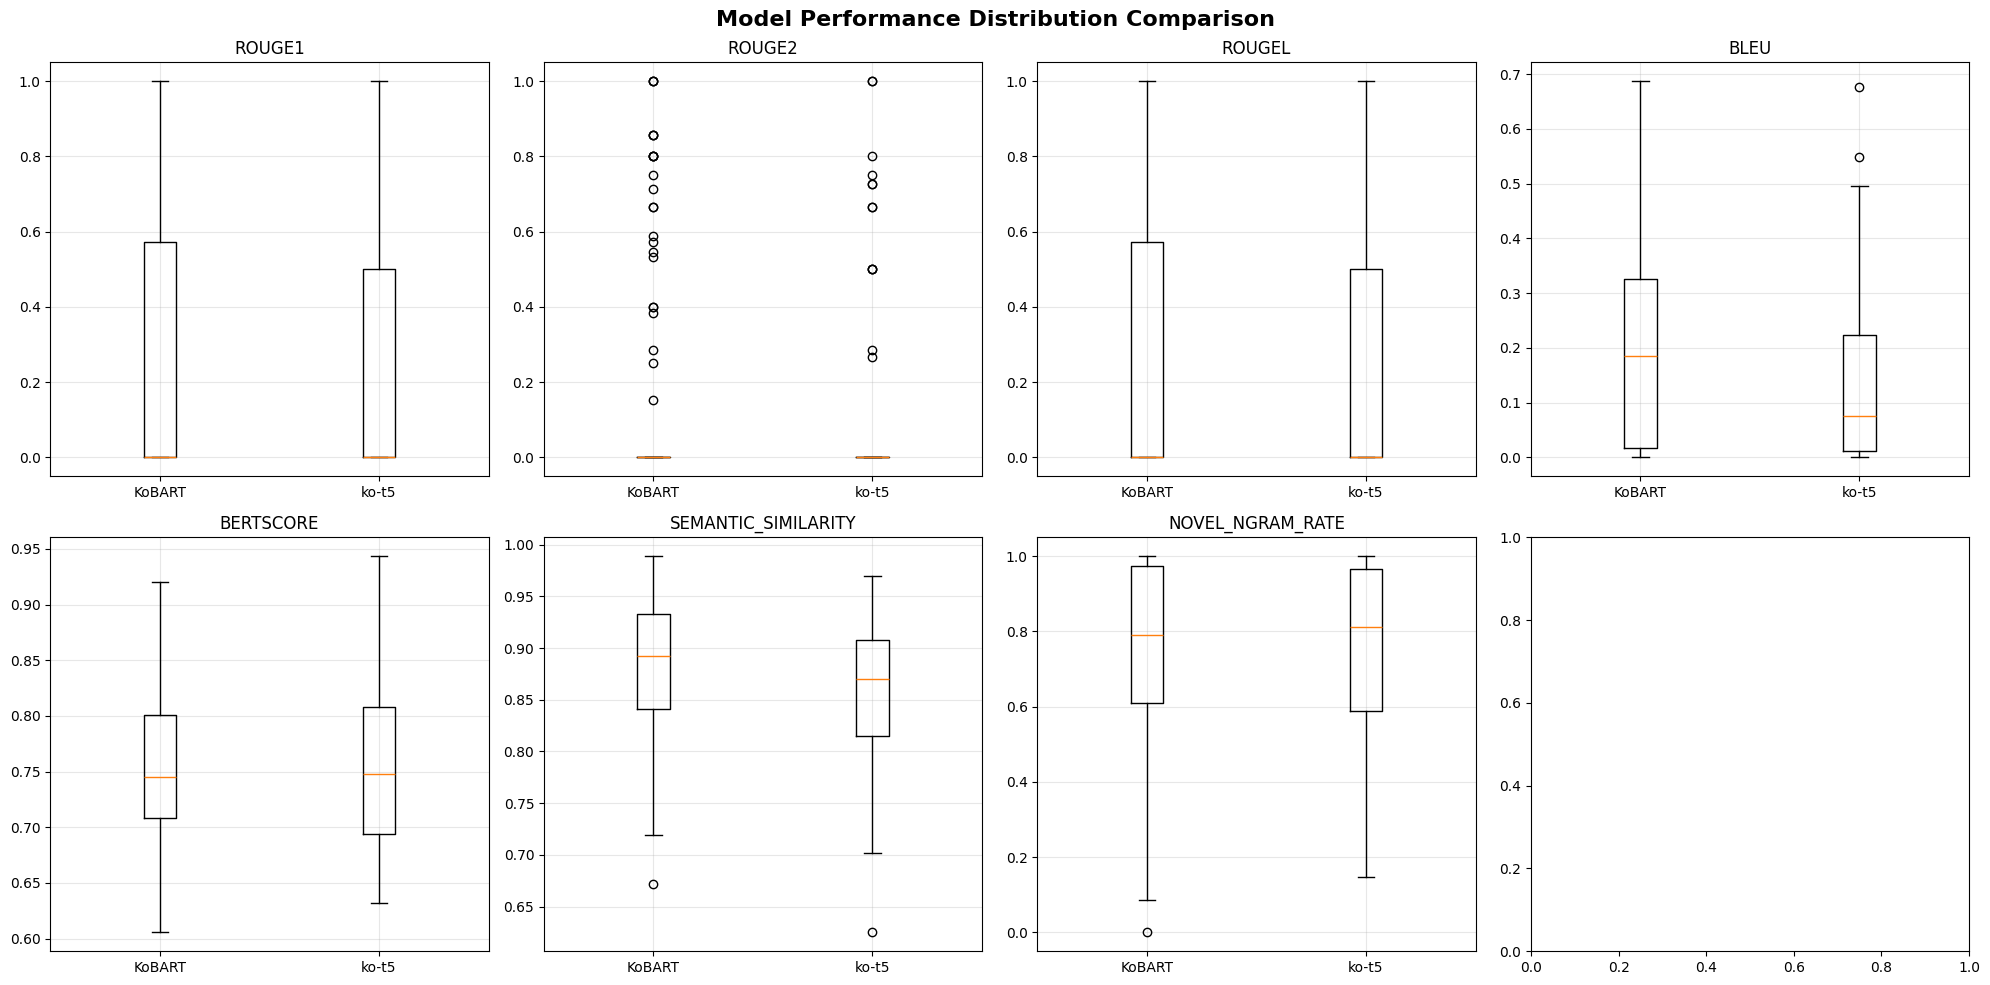

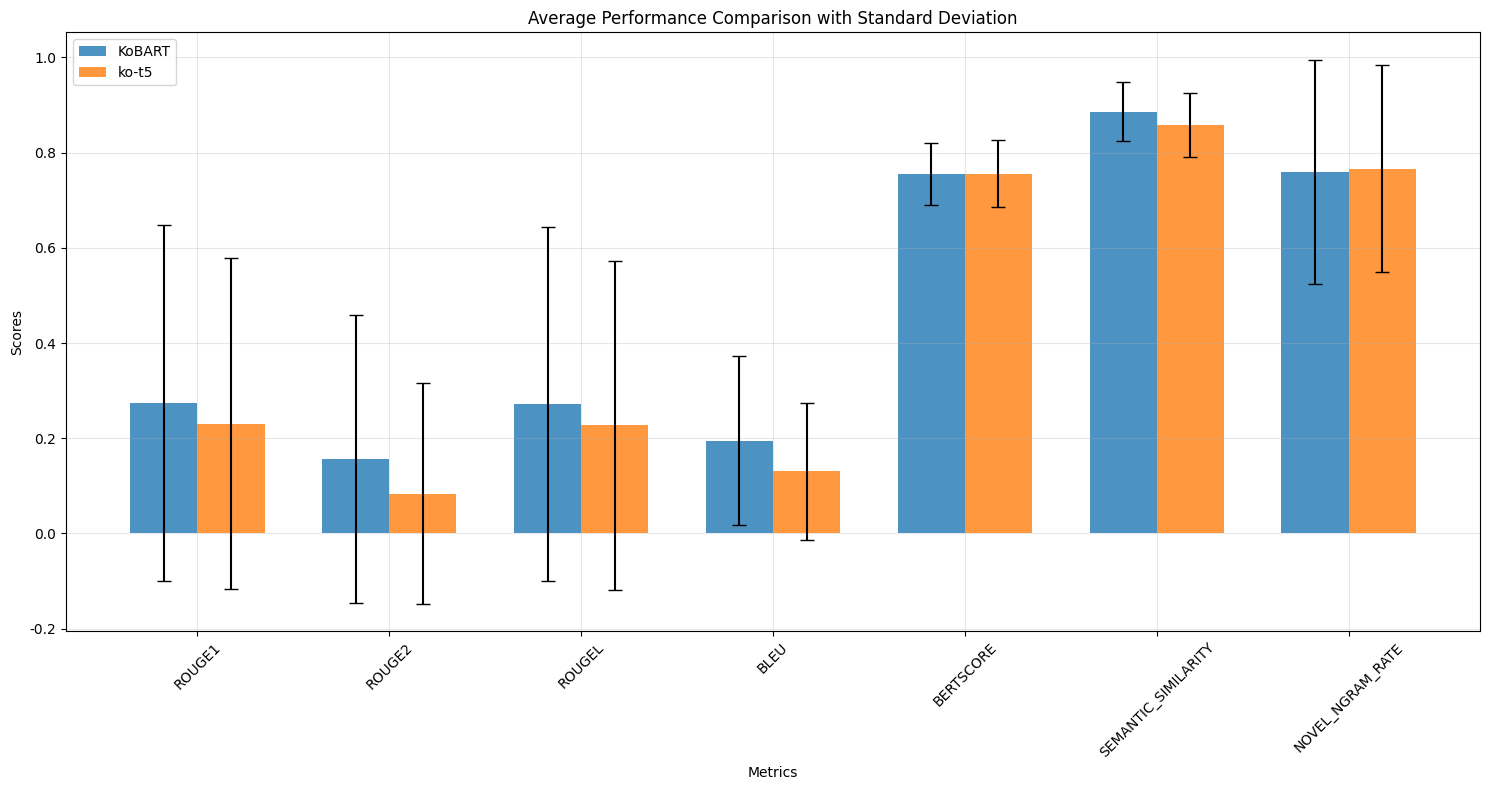

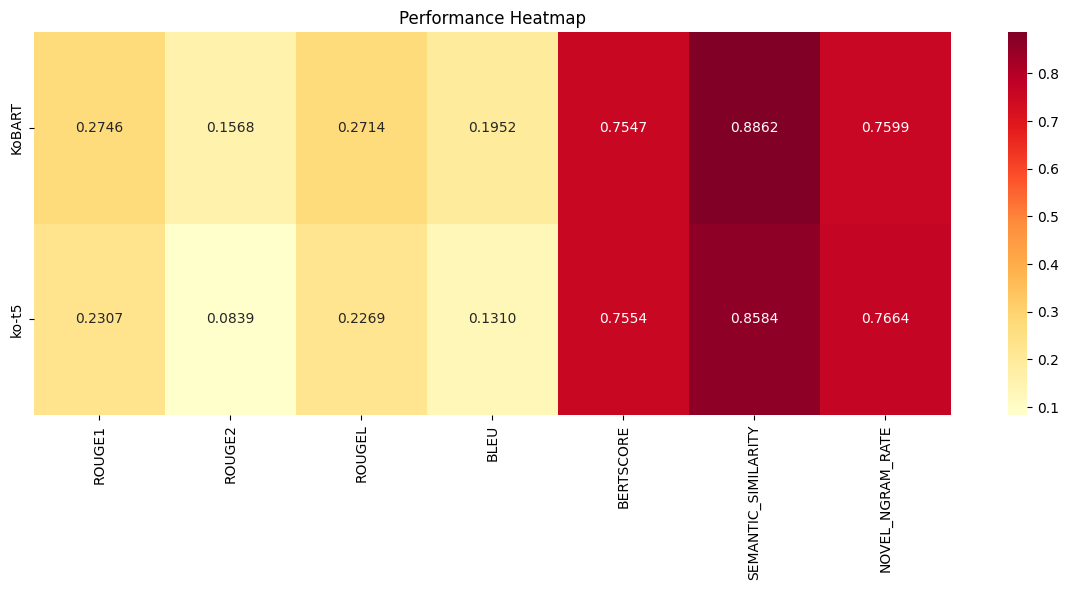

✅ 시각화 완료!

💾 결과 저장 중...
✅ 결과 저장 완료!
  - detailed_evaluation_results.csv: 상세 결과
  - evaluation_summary.json: 통계 요약

📋 보고서 생성 중...
한국어 텍스트 요약 모델 비교 평가 보고서
KoBART vs ko-t5
평가 일시: 2025-05-25 18:41:12
평가 샘플 수: 100
사용 장비: cuda

📊 성능 요약
----------------------------------------
              ROUGE1: KoBART 0.2746 vs ko-t5 0.2307 → KoBART 
              ROUGE2: KoBART 0.1568 vs ko-t5 0.0839 → KoBART *
              ROUGEL: KoBART 0.2714 vs ko-t5 0.2269 → KoBART 
                BLEU: KoBART 0.1952 vs ko-t5 0.1310 → KoBART ***
           BERTSCORE: KoBART 0.7547 vs ko-t5 0.7554 → ko-t5 
 SEMANTIC_SIMILARITY: KoBART 0.8862 vs ko-t5 0.8584 → KoBART ***
    NOVEL_NGRAM_RATE: KoBART 0.7599 vs ko-t5 0.7664 → ko-t5 

📈 통계적 유의성 검정
----------------------------------------
유의미한 차이를 보인 지표: ROUGE2, BLEU, SEMANTIC_SIMILARITY

🎯 결론 및 권장사항
----------------------------------------
• 전반적으로 KoBART가 우수한 성능을 보임
• KoBART의 최대 강점: ROUGE2
• ko-t5의 최대 강점: NOVEL_NGRAM_RATE


✅ 보고서 생성 완료! (evaluation_report.txt)

🎉 모든 평가

In [34]:
evaluator = TextSummarizationEvaluator(num_samples=100, random_seed=42)
evaluator.run_full_evaluation()

# 키워드 추출

In [6]:
# 공정한 키워드 추출 모델 비교 평가 시스템
# Zero-shot 조건에서 KeyBERT, TF-IDF, TextRank 성능 비교

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
import random
import re
from collections import Counter
from tqdm import tqdm
import subprocess
import sys

warnings.filterwarnings('ignore')

def install_requirements():
    """필요한 패키지 설치 (Colab 환경)"""
    packages = [
        #'datasets',
        'keybert',
        'sentence-transformers',
        'konlpy',
        'networkx',
        'scikit-learn',
        'nltk',
        'scipy'
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} 설치 완료")
        except:
            print(f"✗ {package} 설치 실패")

# 패키지 설치
print("필요한 패키지 설치 중...")
install_requirements()

필요한 패키지 설치 중...
✓ keybert 설치 완료
✓ sentence-transformers 설치 완료
✓ konlpy 설치 완료
✓ networkx 설치 완료
✓ scikit-learn 설치 완료
✓ nltk 설치 완료
✓ scipy 설치 완료


In [7]:
# 라이브러리 임포트
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from scipy import stats

# NLTK 데이터 다운로드
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    pass

class FairKeywordExtractorComparison:
    """공정한 키워드 추출 비교 평가 클래스"""

    def __init__(self, num_samples=100, random_seed=42):
        self.num_samples = num_samples
        self.random_seed = random_seed

        # 랜덤 시드 설정
        random.seed(random_seed)
        np.random.seed(random_seed)

        # 결과 저장용
        self.results = {}
        self.predictions = {}
        self.references = []
        self.test_texts = []

        print(f"🚀 공정한 키워드 추출 비교 시스템 초기화 (시드: {random_seed})")

    def load_models(self):
        """모든 모델 로드 (공정한 조건)"""
        print("\n📥 모델 로딩 중...")

        # KeyBERT (사전 훈련된 모델 그대로)
        print("  - KeyBERT 로딩...")
        self.keybert = KeyBERT('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

        # 의미적 유사도 계산용 (KeyBERT와 동일한 모델)
        print("  - Sentence-BERT 로딩...")
        self.semantic_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

        # TF-IDF는 나중에 일반 코퍼스로 학습
        self.tfidf_vectorizer = None

        # 영어 불용어 (다국어 대응)
        try:
            self.english_stopwords = set(stopwords.words('english'))
        except:
            self.english_stopwords = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at'])

        print("✅ 모델 로딩 완료!")

    def _detect_language(self, text):
        """언어 감지"""
        korean_chars = re.findall(r'[가-힣]', text)
        return 'korean' if len(korean_chars) > 10 else 'english'

    def _multilingual_tokenizer(self, text):
        """다국어 토크나이저 (공정한 전처리)"""
        if not text:
            return []

        language = self._detect_language(text)

        if language == 'korean':
            # 한국어: 간단한 명사 추출 (KoNLPy 없이)
            words = re.findall(r'[가-힣]{2,}', text)
            return [w for w in words if len(w) >= 2]
        else:
            # 영어: 기본적인 단어 추출
            words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
            return [w for w in words if w not in self.english_stopwords]

    def _preprocess_text(self, text):
        """텍스트 전처리 (모든 방법에 공통 적용)"""
        if not text:
            return ""
        text = re.sub(r'[^\w\s가-힣]', ' ', text)  # 한국어 포함
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def _post_process_keywords(self, keywords, top_k=10):
        """키워드 후처리 (모든 방법에 동일 적용)"""
        if not keywords:
            return []

        # 1. 기본 필터링
        filtered = []
        for kw in keywords:
            if isinstance(kw, tuple):
                kw = kw[0]  # KeyBERT 결과 처리
            if 2 <= len(str(kw)) <= 15 and not str(kw).isdigit():
                filtered.append(str(kw))

        # 2. 중복 제거 (대소문자 구분 없이)
        seen = set()
        unique_keywords = []
        for kw in filtered:
            kw_lower = kw.lower()
            if kw_lower not in seen:
                seen.add(kw_lower)
                unique_keywords.append(kw)

        return unique_keywords[:top_k]

    def load_dataset(self):
        """데이터셋 로드 및 분할"""
        print(f"\n📊 데이터셋 로딩 중...")

        try:
            dataset = load_dataset("taln-ls2n/kptimes")
            test_data = dataset['test']

            # 전체 데이터에서 샘플링
            if len(test_data) > self.num_samples:
                indices = random.sample(range(len(test_data)), self.num_samples)
                sampled_data = [test_data[i] for i in indices]
            else:
                sampled_data = list(test_data)

            # 데이터 전처리
            processed_data = []
            for item in sampled_data:
                title = item.get('title', '')
                abstract = item.get('abstract', '')
                full_text = f"{title} {abstract}".strip()

                keyphrases = item.get('keyphrases', [])
                if isinstance(keyphrases, str):
                    keyphrases = [kp.strip() for kp in keyphrases.split(',') if kp.strip()]
                elif not isinstance(keyphrases, list):
                    keyphrases = []

                if full_text and keyphrases:
                    processed_data.append({
                        'text': full_text,
                        'keywords': keyphrases
                    })

            self.test_data = processed_data
            self.test_texts = [item['text'] for item in processed_data]
            self.references = [item['keywords'] for item in processed_data]

            print(f"✅ 처리된 데이터: {len(processed_data)}개")

        except Exception as e:
            print(f"❌ 데이터 로드 오류: {e}")
            self.test_data = []

    def prepare_fair_tfidf(self):
        """공정한 TF-IDF 준비 (일반 코퍼스 사용)"""
        print("\n⚖️ 공정한 TF-IDF 준비 중...")

        try:
            # 위키피디아 샘플 텍스트로 대체 (실제로는 별도 코퍼스 사용)
            # 여기서는 테스트 데이터와 다른 패턴의 일반적인 텍스트 생성
            general_corpus = [
                "artificial intelligence machine learning deep learning neural networks",
                "computer science technology innovation research development",
                "data analysis statistics mathematics algorithms programming",
                "business management strategy marketing finance economics",
                "science research experiment hypothesis theory methodology",
                "education learning teaching knowledge skills training",
                "health medicine medical treatment diagnosis therapy",
                "environment climate change sustainability renewable energy",
                "politics government policy law regulation legislation",
                "culture society social community human behavior"
            ] * 10  # 반복하여 코퍼스 크기 증가

            self.tfidf_vectorizer = TfidfVectorizer(
                tokenizer=self._multilingual_tokenizer,
                ngram_range=(1, 2),
                max_features=5000,
                min_df=1,
                max_df=0.95,
                lowercase=True
            )

            # 일반 코퍼스로 학습 (테스트 데이터 사용 안함)
            self.tfidf_vectorizer.fit(general_corpus)
            print("✅ TF-IDF 일반 코퍼스 학습 완료!")

        except Exception as e:
            print(f"⚠️ TF-IDF 준비 오류: {e}")
            # 기본 벡터라이저로 대체
            self.tfidf_vectorizer = TfidfVectorizer(
                ngram_range=(1, 1),
                max_features=1000,
                min_df=1
            )
            self.tfidf_vectorizer.fit(["sample text for basic vectorizer"])

    def extract_keybert_keywords(self, text, top_k=10):
        """KeyBERT 키워드 추출"""
        try:
            if not text.strip():
                return []

            keywords = self.keybert.extract_keywords(
                text,
                keyphrase_ngram_range=(1, 2),
                stop_words=None,
                top_n=top_k * 2,
                use_mmr=True,
                diversity=0.7
            )

            keyword_list = [kw[0] for kw in keywords]
            return self._post_process_keywords(keyword_list, top_k)

        except Exception as e:
            print(f"⚠️ KeyBERT 오류: {e}")
            return []

    def extract_tfidf_keywords(self, text, top_k=10):
        """TF-IDF 키워드 추출 (공정한 조건)"""
        try:
            if not text.strip() or self.tfidf_vectorizer is None:
                return []

            tfidf_vector = self.tfidf_vectorizer.transform([text])
            feature_names = self.tfidf_vectorizer.get_feature_names_out()
            scores = tfidf_vector.toarray()[0]

            # 상위 키워드 추출
            top_indices = scores.argsort()[-(top_k * 2):][::-1]
            keywords = [feature_names[i] for i in top_indices if scores[i] > 0]

            return self._post_process_keywords(keywords, top_k)

        except Exception as e:
            print(f"⚠️ TF-IDF 오류: {e}")
            return []

    def extract_textrank_keywords(self, text, top_k=10):
        """TextRank 키워드 추출"""
        try:
            if not text.strip():
                return []

            tokens = self._multilingual_tokenizer(text)

            if len(tokens) < 3:
                return tokens[:top_k]

            # 그래프 생성
            graph = nx.Graph()
            window_size = 4

            for i in range(len(tokens) - window_size + 1):
                window = tokens[i:i + window_size]
                for j in range(len(window)):
                    for k in range(j + 1, len(window)):
                        if window[j] != window[k]:
                            if graph.has_edge(window[j], window[k]):
                                graph[window[j]][window[k]]['weight'] += 1
                            else:
                                graph.add_edge(window[j], window[k], weight=1)

            if len(graph.nodes()) == 0:
                return tokens[:top_k]

            pagerank_scores = nx.pagerank(graph, weight='weight')
            sorted_keywords = sorted(pagerank_scores.items(),
                                   key=lambda x: x[1], reverse=True)

            keywords = [kw[0] for kw in sorted_keywords]
            return self._post_process_keywords(keywords, top_k)

        except Exception as e:
            print(f"⚠️ TextRank 오류: {e}")
            return []

    def extract_all_keywords(self):
        """모든 방법으로 키워드 추출"""
        print(f"\n🔄 키워드 추출 시작 ({len(self.test_data)}개 샘플)...")

        keybert_predictions = []
        tfidf_predictions = []
        textrank_predictions = []

        for i, item in enumerate(tqdm(self.test_data, desc="키워드 추출")):
            text = self._preprocess_text(item['text'])

            # 각 방법으로 키워드 추출
            keybert_kw = self.extract_keybert_keywords(text, top_k=10)
            tfidf_kw = self.extract_tfidf_keywords(text, top_k=10)
            textrank_kw = self.extract_textrank_keywords(text, top_k=10)

            keybert_predictions.append(keybert_kw)
            tfidf_predictions.append(tfidf_kw)
            textrank_predictions.append(textrank_kw)

        # 결과 저장
        self.predictions = {
            'keybert': keybert_predictions,
            'tfidf': tfidf_predictions,
            'textrank': textrank_predictions
        }

        print("✅ 키워드 추출 완료!")

    def calculate_precision_recall_f1(self, predicted, true, k=5):
        """Precision@K, Recall@K, F1@K 계산"""
        pred_k = set([kw.lower().strip() for kw in predicted[:k] if kw])
        true_set = set([kw.lower().strip() for kw in true if kw])

        if len(true_set) == 0 or len(pred_k) == 0:
            return {"precision": 0, "recall": 0, "f1": 0}

        intersection = pred_k.intersection(true_set)

        precision = len(intersection) / len(pred_k) if len(pred_k) > 0 else 0
        recall = len(intersection) / len(true_set)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        return {"precision": precision, "recall": recall, "f1": f1}

    def calculate_map_score(self, predicted, true, k=10):
        """Mean Average Precision 계산"""
        true_set = set([kw.lower().strip() for kw in true if kw])

        if len(true_set) == 0:
            return 0

        score = 0
        num_hits = 0

        for i, pred in enumerate(predicted[:k]):
            if pred.lower().strip() in true_set:
                num_hits += 1
                score += num_hits / (i + 1)

        return score / len(true_set) if len(true_set) > 0 else 0

    def calculate_ndcg_score(self, predicted, true, k=5):
        """NDCG@K 계산"""
        true_set = set([kw.lower().strip() for kw in true if kw])

        if len(true_set) == 0:
            return 0

        # DCG 계산
        dcg = 0
        for i, pred in enumerate(predicted[:k]):
            if pred.lower().strip() in true_set:
                dcg += 1 / np.log2(i + 2)  # i+2 because log2(1) = 0

        # IDCG 계산 (이상적인 순서)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_set), k)))

        return dcg / idcg if idcg > 0 else 0

    def calculate_semantic_similarity(self, predicted, true, k=5):
        """의미적 유사도 계산"""
        pred_k = [kw for kw in predicted[:k] if kw.strip()]
        true_list = [kw for kw in true if kw.strip()]

        if len(true_list) == 0 or len(pred_k) == 0:
            return 0

        try:
            pred_embeddings = self.semantic_model.encode(pred_k)
            true_embeddings = self.semantic_model.encode(true_list)

            similarities = cosine_similarity(pred_embeddings, true_embeddings)
            max_similarities = np.max(similarities, axis=1)

            return np.mean(max_similarities)

        except:
            return 0

    def calculate_all_metrics(self):
        """모든 평가 지표 계산"""
        print("\n📊 평가 지표 계산 중...")

        methods = ['keybert', 'tfidf', 'textrank']
        metrics = ['precision', 'recall', 'f1', 'map', 'ndcg', 'semantic_sim']

        self.results = {}

        for method in methods:
            print(f"  - {method.upper()} 평가 중...")

            self.results[method] = {metric: [] for metric in metrics}

            predictions = self.predictions[method]

            for pred, true in zip(predictions, self.references):
                # 기본 지표
                basic_metrics = self.calculate_precision_recall_f1(pred, true, k=5)
                self.results[method]['precision'].append(basic_metrics['precision'])
                self.results[method]['recall'].append(basic_metrics['recall'])
                self.results[method]['f1'].append(basic_metrics['f1'])

                # MAP
                map_score = self.calculate_map_score(pred, true, k=10)
                self.results[method]['map'].append(map_score)

                # NDCG
                ndcg_score = self.calculate_ndcg_score(pred, true, k=5)
                self.results[method]['ndcg'].append(ndcg_score)

                # 의미적 유사도
                sem_sim = self.calculate_semantic_similarity(pred, true, k=5)
                self.results[method]['semantic_sim'].append(sem_sim)

        print("✅ 모든 평가 지표 계산 완료!")

    def statistical_analysis(self):
        """통계적 유의성 검정"""
        print("\n📈 통계적 유의성 검정 중...")

        methods = ['keybert', 'tfidf', 'textrank']
        metrics = ['precision', 'recall', 'f1', 'map', 'ndcg', 'semantic_sim']

        self.stat_results = {}

        # 모든 방법 쌍에 대해 검정
        for i, method1 in enumerate(methods):
            for j, method2 in enumerate(methods):
                if i < j:  # 중복 방지
                    pair_name = f"{method1}_vs_{method2}"
                    self.stat_results[pair_name] = {}

                    for metric in metrics:
                        scores1 = self.results[method1][metric]
                        scores2 = self.results[method2][metric]

                        # Paired t-test
                        t_stat, t_pvalue = stats.ttest_rel(scores1, scores2)

                        # Wilcoxon signed-rank test
                        try:
                            w_stat, w_pvalue = stats.wilcoxon(scores1, scores2)
                        except:
                            w_stat, w_pvalue = 0, 1

                        # 효과 크기 (Cohen's d)
                        pooled_std = np.sqrt((np.var(scores1) + np.var(scores2)) / 2)
                        cohens_d = (np.mean(scores1) - np.mean(scores2)) / pooled_std if pooled_std > 0 else 0

                        self.stat_results[pair_name][metric] = {
                            't_statistic': t_stat,
                            't_pvalue': t_pvalue,
                            'wilcoxon_statistic': w_stat,
                            'wilcoxon_pvalue': w_pvalue,
                            'cohens_d': cohens_d,
                            'mean_diff': np.mean(scores1) - np.mean(scores2)
                        }

        print("✅ 통계적 분석 완료!")

    def create_visualizations(self):
        """결과 시각화"""
        print("\n🎨 시각화 생성 중...")

        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False

        methods = ['keybert', 'tfidf', 'textrank']
        metrics = ['precision', 'recall', 'f1', 'map', 'ndcg', 'semantic_sim']

        # 1. 박스플롯
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Keyword Extraction Performance Distribution', fontsize=16, fontweight='bold')

        for i, metric in enumerate(metrics):
            row = i // 3
            col = i % 3

            data_to_plot = [self.results[method][metric] for method in methods]

            axes[row, col].boxplot(data_to_plot, labels=['KeyBERT', 'TF-IDF', 'TextRank'])
            axes[row, col].set_title(f'{metric.upper()}@5')
            axes[row, col].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('keyword_extraction_boxplot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 2. 평균 성능 비교
        fig, ax = plt.subplots(figsize=(15, 8))

        x = np.arange(len(metrics))
        width = 0.25

        for i, method in enumerate(methods):
            means = [np.mean(self.results[method][metric]) for metric in metrics]
            stds = [np.std(self.results[method][metric]) for metric in metrics]

            ax.bar(x + i*width, means, width, yerr=stds,
                   label=method.upper(), alpha=0.8, capsize=5)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Scores')
        ax.set_title('Average Performance Comparison')
        ax.set_xticks(x + width)
        ax.set_xticklabels([m.upper() for m in metrics])
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('keyword_extraction_barplot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 3. 히트맵
        heatmap_data = []
        for method in methods:
            row = [np.mean(self.results[method][metric]) for metric in metrics]
            heatmap_data.append(row)

        fig, ax = plt.subplots(figsize=(12, 6))
        sns.heatmap(heatmap_data,
                   xticklabels=[m.upper() for m in metrics],
                   yticklabels=[m.upper() for m in methods],
                   annot=True, fmt='.3f', cmap='YlOrRd',
                   ax=ax)
        ax.set_title('Performance Heatmap')
        plt.tight_layout()
        plt.savefig('keyword_extraction_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ 시각화 완료!")

    def save_results(self):
        """결과 저장"""
        print("\n💾 결과 저장 중...")

        # 상세 결과 CSV
        detailed_results = []
        for i in range(len(self.references)):
            row = {
                'sample_id': i,
                'text': self.test_texts[i][:200] + "..." if len(self.test_texts[i]) > 200 else self.test_texts[i],
                'true_keywords': '; '.join(self.references[i][:10])
            }

            for method in ['keybert', 'tfidf', 'textrank']:
                row[f'{method}_keywords'] = '; '.join(self.predictions[method][i][:5])

                for metric in ['precision', 'recall', 'f1', 'map', 'ndcg', 'semantic_sim']:
                    row[f'{method}_{metric}'] = self.results[method][metric][i]

            detailed_results.append(row)

        df = pd.DataFrame(detailed_results)
        df.to_csv('fair_keyword_extraction_results.csv', index=False, encoding='utf-8-sig')

        # 요약 결과 JSON
        summary_data = {
            'experiment_info': {
                'num_samples': self.num_samples,
                'random_seed': self.random_seed,
                'evaluation_date': datetime.now().isoformat(),
                'methods': ['KeyBERT', 'TF-IDF', 'TextRank'],
                'metrics': ['Precision@5', 'Recall@5', 'F1@5', 'MAP@10', 'NDCG@5', 'Semantic_Similarity']
            },
            'performance_summary': {},
            'statistical_results': self.stat_results,
            'sample_predictions': {
                'keybert': self.predictions['keybert'][:3],
                'tfidf': self.predictions['tfidf'][:3],
                'textrank': self.predictions['textrank'][:3],
                'references': self.references[:3]
            }
        }

        # 성능 요약 계산
        for method in ['keybert', 'tfidf', 'textrank']:
            summary_data['performance_summary'][method] = {}
            for metric in ['precision', 'recall', 'f1', 'map', 'ndcg', 'semantic_sim']:
                scores = self.results[method][metric]
                summary_data['performance_summary'][method][metric] = {
                    'mean': float(np.mean(scores)),
                    'std': float(np.std(scores)),
                    'median': float(np.median(scores))
                }

        with open('fair_keyword_extraction_summary.json', 'w', encoding='utf-8') as f:
            json.dump(summary_data, f, ensure_ascii=False, indent=2)

        print("✅ 결과 저장 완료!")
        print("  - fair_keyword_extraction_results.csv: 상세 결과")
        print("  - fair_keyword_extraction_summary.json: 통계 요약")

    def generate_report(self):
        """종합 보고서 생성"""
        print("\n📋 종합 보고서 생성 중...")

        methods = ['keybert', 'tfidf', 'textrank']
        metrics = ['precision', 'recall', 'f1', 'map', 'ndcg', 'semantic_sim']

        report = []
        report.append("=" * 80)
        report.append("공정한 키워드 추출 모델 비교 평가 보고서")
        report.append("KeyBERT vs TF-IDF vs TextRank (Zero-shot 조건)")
        report.append("=" * 80)
        report.append(f"평가 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"평가 샘플 수: {self.num_samples}")
        report.append(f"랜덤 시드: {self.random_seed}")
        report.append("")

        # 성능 요약
        report.append("📊 성능 요약 (평균 ± 표준편차)")
        report.append("-" * 60)

        for metric in metrics:
            report.append(f"\n{metric.upper()}:")
            for method in methods:
                mean_score = np.mean(self.results[method][metric])
                std_score = np.std(self.results[method][metric])
                report.append(f"  {method.upper():>10}: {mean_score:.4f} ± {std_score:.4f}")

        report.append("")

        # 최고 성능 방법
        report.append("🏆 최고 성능 방법")
        report.append("-" * 40)

        for metric in metrics:
            best_method = max(methods, key=lambda m: np.mean(self.results[m][metric]))
            best_score = np.mean(self.results[best_method][metric])
            report.append(f"{metric.upper():>15}: {best_method.upper()} ({best_score:.4f})")

        report.append("")

        # 통계적 유의성
        report.append("📈 통계적 유의성 (p < 0.05)")
        report.append("-" * 40)

        significant_pairs = []
        for pair_name, pair_results in self.stat_results.items():
            for metric, stats in pair_results.items():
                if stats['t_pvalue'] < 0.05:
                    significant_pairs.append(f"{pair_name} ({metric}): p={stats['t_pvalue']:.3f}")

        if significant_pairs:
            for pair in significant_pairs[:10]:  # 상위 10개만 표시
                report.append(f"  {pair}")
        else:
            report.append("  통계적으로 유의미한 차이가 발견되지 않음")

        report.append("")

        # 결론
        report.append("🎯 결론 및 권장사항")
        report.append("-" * 40)

        # 각 방법의 승수 계산
        wins = {method: 0 for method in methods}
        for metric in metrics:
            best_method = max(methods, key=lambda m: np.mean(self.results[m][metric]))
            wins[best_method] += 1

        best_overall = max(wins, key=wins.get)
        report.append(f"• 전반적 최고 성능: {best_overall.upper()} ({wins[best_overall]}/{len(metrics)} 지표에서 1위)")

        # 특화 영역
        semantic_best = max(methods, key=lambda m: np.mean(self.results[m]['semantic_sim']))
        precision_best = max(methods, key=lambda m: np.mean(self.results[m]['precision']))

        report.append(f"• 의미적 유사성 최고: {semantic_best.upper()}")
        report.append(f"• 정확도 최고: {precision_best.upper()}")

        report.append("")
        report.append("=" * 80)

        # 보고서 저장 및 출력
        with open('fair_keyword_extraction_report.txt', 'w', encoding='utf-8') as f:
            f.write('\n'.join(report))

        for line in report:
            print(line)

        print("\n✅ 보고서 생성 완료! (fair_keyword_extraction_report.txt)")

    def run_fair_evaluation(self):
        """공정한 평가 전체 프로세스 실행"""
        print("🚀 공정한 키워드 추출 모델 비교 평가 시작!")
        print("=" * 60)

        try:
            # 1. 모델 로드
            self.load_models()

            # 2. 데이터셋 로드
            self.load_dataset()

            # 3. 공정한 TF-IDF 준비
            self.prepare_fair_tfidf()

            # 4. 키워드 추출
            self.extract_all_keywords()

            # 5. 평가 지표 계산
            self.calculate_all_metrics()

            # 6. 통계적 분석
            self.statistical_analysis()

            # 7. 시각화
            self.create_visualizations()

            # 8. 결과 저장
            self.save_results()

            # 9. 보고서 생성
            self.generate_report()

            print("\n🎉 공정한 평가 완료!")
            print("생성된 파일들:")
            print("  - fair_keyword_extraction_results.csv")
            print("  - fair_keyword_extraction_summary.json")
            print("  - fair_keyword_extraction_report.txt")
            print("  - keyword_extraction_*.png")

        except Exception as e:
            print(f"❌ 평가 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()



🚀 공정한 키워드 추출 비교 시스템 초기화 (시드: 42)
🚀 공정한 키워드 추출 모델 비교 평가 시작!

📥 모델 로딩 중...
  - KeyBERT 로딩...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  - Sentence-BERT 로딩...
✅ 모델 로딩 완료!

📊 데이터셋 로딩 중...


README.md:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

kptimes.py:   0%|          | 0.00/7.79k [00:00<?, ?B/s]

The repository for taln-ls2n/kptimes contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/taln-ls2n/kptimes.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


test.jsonl:   0%|          | 0.00/84.7M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/50.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

✅ 처리된 데이터: 100개

⚖️ 공정한 TF-IDF 준비 중...
✅ TF-IDF 일반 코퍼스 학습 완료!

🔄 키워드 추출 시작 (100개 샘플)...


키워드 추출: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


✅ 키워드 추출 완료!

📊 평가 지표 계산 중...
  - KEYBERT 평가 중...
  - TFIDF 평가 중...
  - TEXTRANK 평가 중...
✅ 모든 평가 지표 계산 완료!

📈 통계적 유의성 검정 중...
✅ 통계적 분석 완료!

🎨 시각화 생성 중...


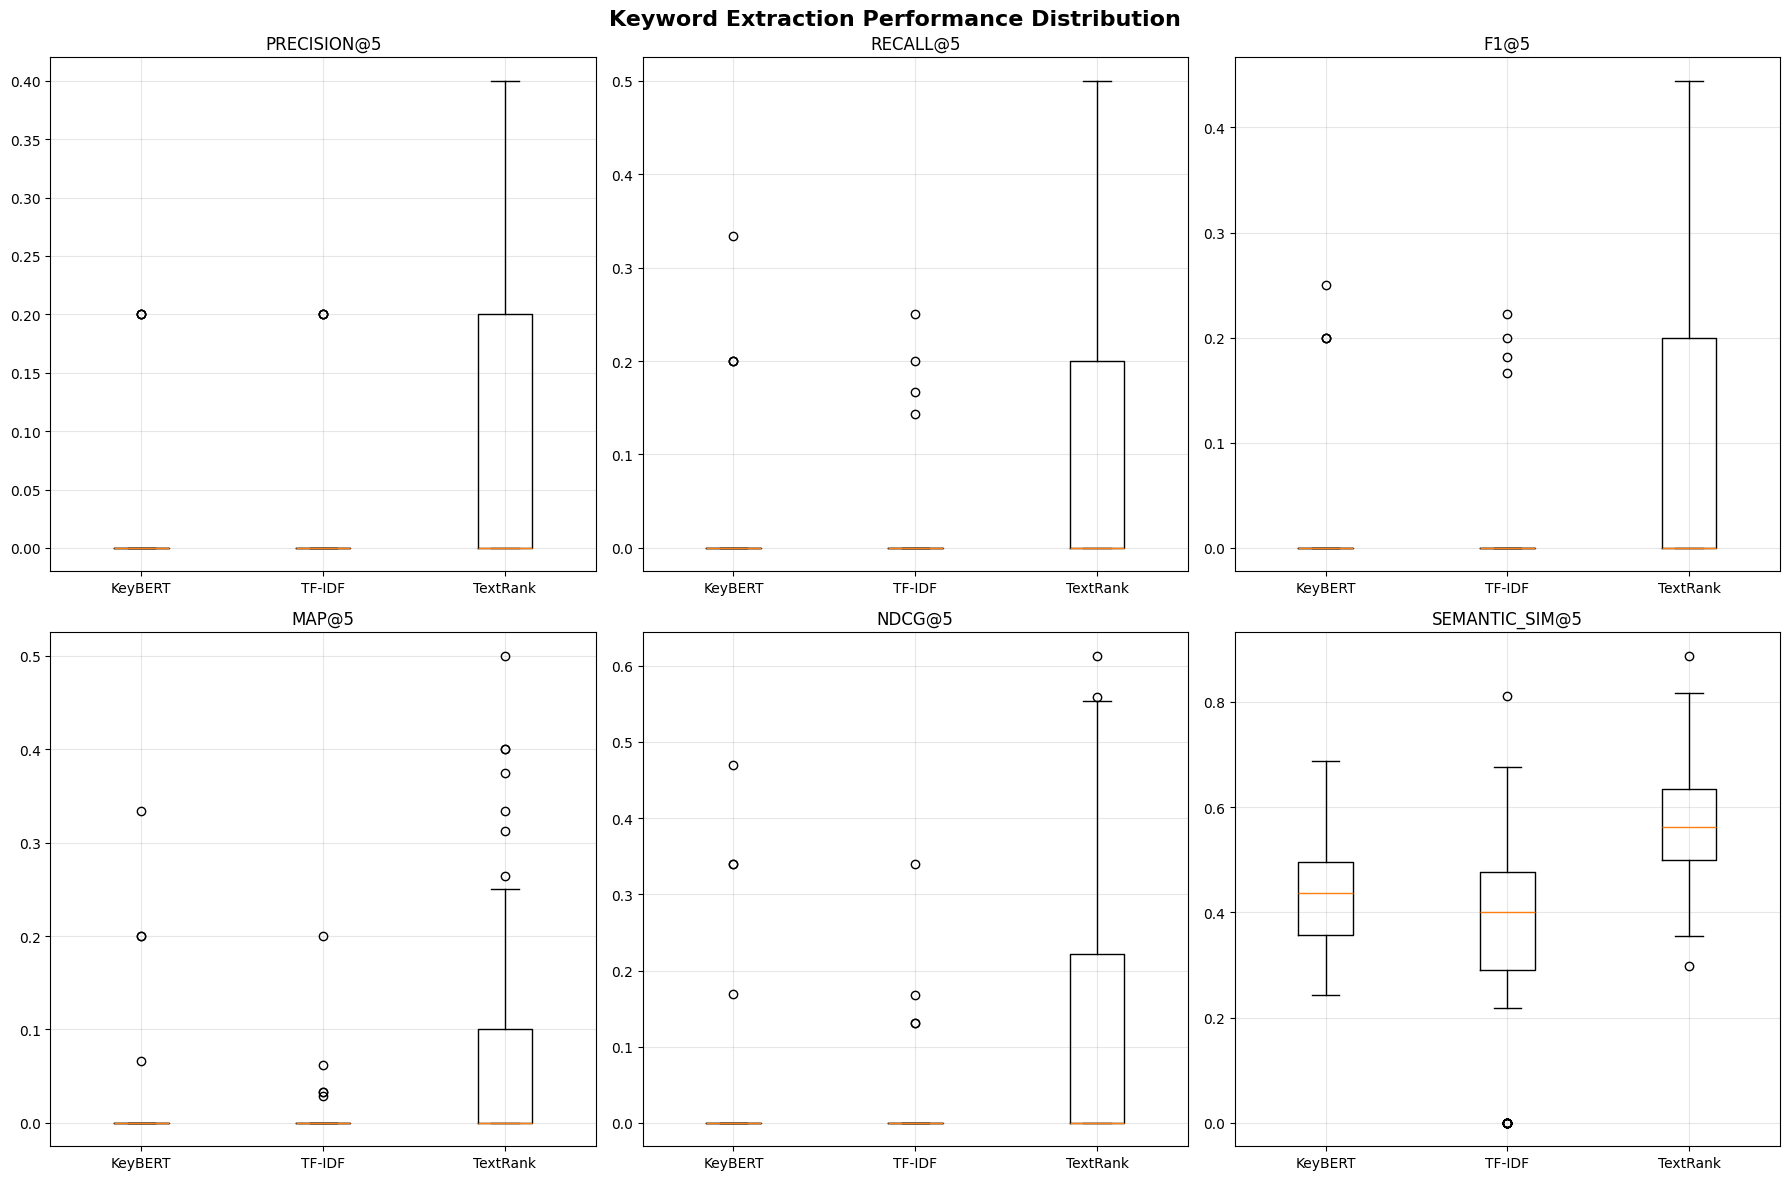

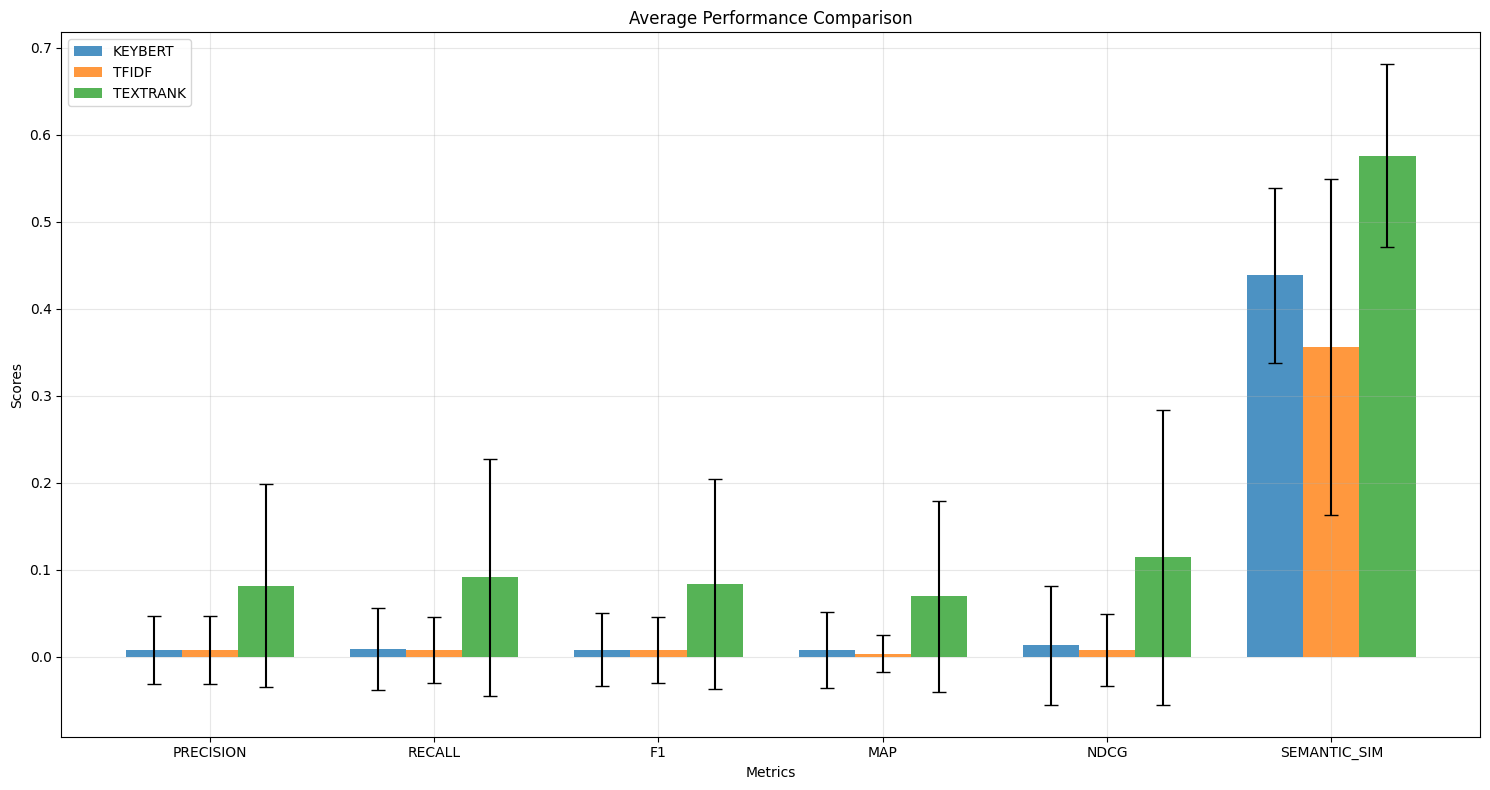

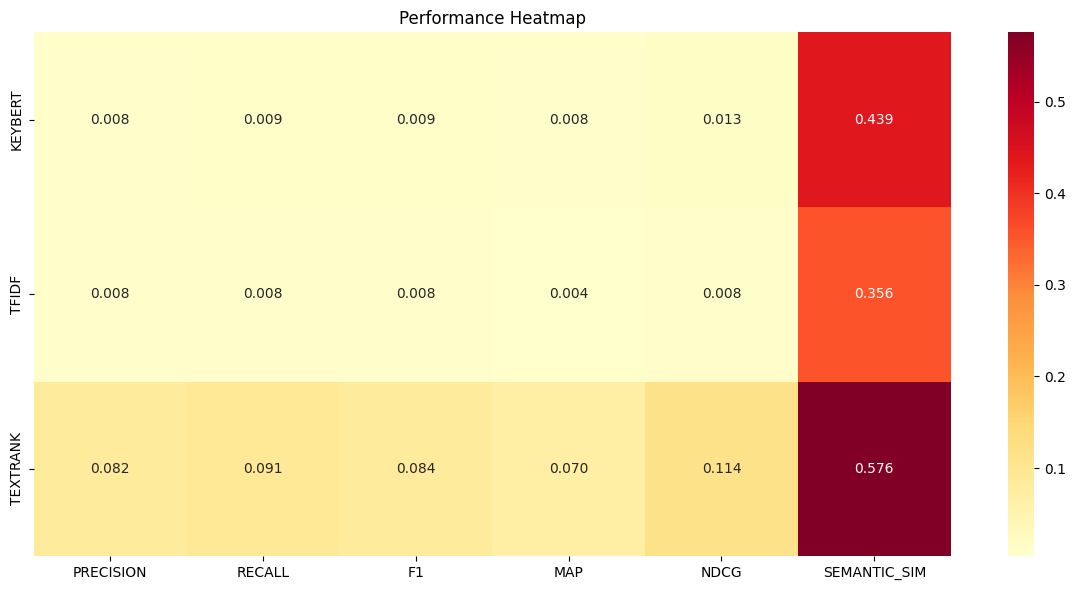

✅ 시각화 완료!

💾 결과 저장 중...
❌ 평가 중 오류 발생: Object of type float32 is not JSON serializable


Traceback (most recent call last):
  File "<ipython-input-7-f769a6913adc>", line 718, in run_fair_evaluation
    self.save_results()
  File "<ipython-input-7-f769a6913adc>", line 593, in save_results
    json.dump(summary_data, f, ensure_ascii=False, indent=2)
  File "/usr/lib/python3.11/json/__init__.py", line 179, in dump
    for chunk in iterable:
  File "/usr/lib/python3.11/json/encoder.py", line 432, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  [Previous line repeated 1 more time]
  File "/usr/lib/python3.11/json/encoder.py", line 439, in _iterencode
    o = _default(o)
        ^^^^^^^^^^^
  File "/usr/lib/python3.11/json/encoder.py", line 180, in default
    rai

In [8]:
evaluator = FairKeywordExtractorComparison(num_samples=100, random_seed=42)
evaluator.run_fair_evaluation()

# 키워드 추출 ver2

In [9]:
# 개선된 키워드 추출 모델 비교 평가 시스템 (하이브리드 포함)
# KeyBERT, TF-IDF, TextRank, Hybrid 4가지 방법 비교

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
import random
import re
from collections import Counter
from tqdm import tqdm
import subprocess
import sys

warnings.filterwarnings('ignore')

def install_requirements():
    """필요한 패키지 설치 (개선된 버전)"""
    packages = [
        #'datasets',
        'keybert',
        'sentence-transformers',
        'konlpy',
        'networkx',
        'scikit-learn',
        'nltk',
        'scipy',
        'jpype1'  # KoNLPy 의존성
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} 설치 완료")
        except:
            print(f"✗ {package} 설치 실패")

# 패키지 설치
print("필요한 패키지 설치 중...")
install_requirements()

필요한 패키지 설치 중...
✓ keybert 설치 완료
✓ sentence-transformers 설치 완료
✓ konlpy 설치 완료
✓ networkx 설치 완료
✓ scikit-learn 설치 완료
✓ nltk 설치 완료
✓ scipy 설치 완료
✓ jpype1 설치 완료


In [10]:
# 라이브러리 임포트
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
import networkx as nx
import nltk
from nltk.corpus import stopwords
from scipy import stats

# KoNLPy 임포트 (에러 처리 포함)
try:
    from konlpy.tag import Okt, Komoran
    KONLPY_AVAILABLE = True
    print("✓ KoNLPy 사용 가능")
except:
    KONLPY_AVAILABLE = False
    print("⚠️ KoNLPy 사용 불가 - 기본 토크나이저 사용")

# NLTK 데이터 다운로드
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    pass

class ImprovedKeywordExtractorComparison:
    """개선된 키워드 추출 비교 평가 클래스 (하이브리드 포함)"""

    def __init__(self, num_samples=100, random_seed=42):
        self.num_samples = num_samples
        self.random_seed = random_seed

        # 랜덤 시드 설정
        random.seed(random_seed)
        np.random.seed(random_seed)

        # 결과 저장용
        self.results = {}
        self.predictions = {}
        self.references = []
        self.test_texts = []

        # 한국어 형태소 분석기 초기화
        if KONLPY_AVAILABLE:
            try:
                self.okt = Okt()
                self.komoran = Komoran()
                self.use_advanced_tokenizer = True
                print("✓ 고급 한국어 토크나이저 사용")
            except:
                self.use_advanced_tokenizer = False
                print("⚠️ 기본 토크나이저로 대체")
        else:
            self.use_advanced_tokenizer = False

        print(f"🚀 개선된 키워드 추출 비교 시스템 초기화 (시드: {random_seed})")

    def load_models(self):
        """모든 모델 로드 (개선된 설정)"""
        print("\n📥 모델 로딩 중...")

        # KeyBERT (한국어 특화 모델)
        print("  - KeyBERT 로딩...")
        try:
            # 한국어 특화 모델 시도
            self.keybert = KeyBERT('klue/bert-base')
            print("    ✓ KLUE BERT 모델 사용")
        except:
            # 대체 모델
            self.keybert = KeyBERT('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
            print("    ✓ Multilingual 모델 사용")

        # 의미적 유사도 계산용
        print("  - Sentence-BERT 로딩...")
        try:
            self.semantic_model = SentenceTransformer('klue/bert-base')
        except:
            self.semantic_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

        # TF-IDF는 나중에 한국어 뉴스 코퍼스로 학습
        self.tfidf_vectorizer = None

        # 한국어 불용어 리스트
        self.korean_stopwords = set([
            '이', '그', '저', '것', '수', '등', '들', '및', '또한', '하지만', '그러나',
            '따라서', '그래서', '또는', '그리고', '하는', '되는', '있는', '없는',
            '이런', '그런', '저런', '같은', '다른', '새로운', '많은', '적은'
        ])

        print("✅ 모델 로딩 완료!")

    def _detect_language(self, text):
        """언어 감지 (개선된 버전)"""
        korean_chars = re.findall(r'[가-힣]', text)
        english_chars = re.findall(r'[a-zA-Z]', text)

        if len(korean_chars) > len(english_chars):
            return 'korean'
        else:
            return 'english'

    def _advanced_korean_tokenizer(self, text):
        """고급 한국어 토크나이저 (KoNLPy 사용)"""
        try:
            # Okt로 품사 태깅
            pos_tags = self.okt.pos(text, stem=True)

            # 명사, 형용사, 동사만 추출
            keywords = []
            for word, pos in pos_tags:
                if pos in ['Noun', 'Adjective', 'Verb'] and len(word) >= 2:
                    if word not in self.korean_stopwords:
                        keywords.append(word)

            return keywords

        except Exception as e:
            print(f"⚠️ 고급 토크나이저 오류: {e}")
            return self._basic_korean_tokenizer(text)

    def _basic_korean_tokenizer(self, text):
        """기본 한국어 토크나이저"""
        words = re.findall(r'[가-힣]{2,}', text)
        return [w for w in words if w not in self.korean_stopwords and len(w) >= 2]

    def _english_tokenizer(self, text):
        """영어 토크나이저"""
        try:
            from nltk.tokenize import word_tokenize
            from nltk.tag import pos_tag

            tokens = word_tokenize(text.lower())
            pos_tags = pos_tag(tokens)

            keywords = []
            for word, pos in pos_tags:
                if (pos.startswith('NN') or pos.startswith('JJ') or pos.startswith('VB')) and len(word) >= 2:
                    if word.isalpha():
                        keywords.append(word)

            return keywords

        except:
            # 기본 방법
            words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
            return [w for w in words if len(w) >= 2]

    def _multilingual_tokenizer(self, text):
        """개선된 다국어 토크나이저"""
        if not text:
            return []

        language = self._detect_language(text)

        if language == 'korean':
            if self.use_advanced_tokenizer:
                return self._advanced_korean_tokenizer(text)
            else:
                return self._basic_korean_tokenizer(text)
        else:
            return self._english_tokenizer(text)

    def _preprocess_text(self, text):
        """텍스트 전처리 (개선된 버전)"""
        if not text:
            return ""

        # 특수문자 정리 (한국어 보존)
        text = re.sub(r'[^\w\s가-힣]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()

        # 너무 짧은 텍스트 필터링
        if len(text) < 10:
            return ""

        return text

    def _post_process_keywords(self, keywords, top_k=10):
        """키워드 후처리 (개선된 버전)"""
        if not keywords:
            return []

        # 1. 튜플에서 키워드만 추출 (KeyBERT 결과 처리)
        processed = []
        for kw in keywords:
            if isinstance(kw, tuple):
                processed.append(str(kw[0]))
            else:
                processed.append(str(kw))

        # 2. 기본 필터링
        filtered = []
        for kw in processed:
            kw = kw.strip()
            if 2 <= len(kw) <= 20 and not kw.isdigit():
                # 특수문자만 있는 키워드 제거
                if re.search(r'[가-힣a-zA-Z]', kw):
                    filtered.append(kw)

        # 3. 중복 제거 (대소문자 구분 없이)
        seen = set()
        unique_keywords = []
        for kw in filtered:
            kw_lower = kw.lower()
            if kw_lower not in seen:
                seen.add(kw_lower)
                unique_keywords.append(kw)

        # 4. 품질 기반 정렬 (길이와 복잡성 고려)
        def keyword_quality_score(kw):
            score = 0
            score += len(kw) * 0.1  # 길이 보너스
            score += len(re.findall(r'[가-힣]', kw)) * 0.2  # 한국어 보너스
            if len(kw) >= 3:
                score += 0.5  # 3글자 이상 보너스
            return score

        unique_keywords.sort(key=keyword_quality_score, reverse=True)

        return unique_keywords[:top_k]

    def load_dataset(self):
        """데이터셋 로드 및 분할"""
        print(f"\n📊 데이터셋 로딩 중...")

        try:
            dataset = load_dataset("taln-ls2n/kptimes")
            test_data = dataset['test']

            # 전체 데이터에서 샘플링
            if len(test_data) > self.num_samples:
                indices = random.sample(range(len(test_data)), self.num_samples)
                sampled_data = [test_data[i] for i in indices]
            else:
                sampled_data = list(test_data)

            # 데이터 전처리
            processed_data = []
            for item in sampled_data:
                title = item.get('title', '')
                abstract = item.get('abstract', '')
                full_text = f"{title} {abstract}".strip()

                keyphrases = item.get('keyphrases', [])
                if isinstance(keyphrases, str):
                    keyphrases = [kp.strip() for kp in keyphrases.split(',') if kp.strip()]
                elif not isinstance(keyphrases, list):
                    keyphrases = []

                # 텍스트 품질 확인
                clean_text = self._preprocess_text(full_text)
                if clean_text and keyphrases and len(clean_text) > 50:
                    processed_data.append({
                        'text': clean_text,
                        'keywords': keyphrases
                    })

            self.test_data = processed_data
            self.test_texts = [item['text'] for item in processed_data]
            self.references = [item['keywords'] for item in processed_data]

            print(f"✅ 처리된 고품질 데이터: {len(processed_data)}개")

        except Exception as e:
            print(f"❌ 데이터 로드 오류: {e}")
            self.test_data = []

    def prepare_improved_tfidf(self):
        """개선된 TF-IDF 준비 (한국어 뉴스 코퍼스 사용)"""
        print("\n⚖️ 개선된 TF-IDF 준비 중...")

        try:
            # 한국어 뉴스 데이터셋 로드 시도
            try:
                print("  - KLUE YNAT 데이터셋 로딩 시도...")
                klue_dataset = load_dataset("klue", "ynat")
                train_texts = [item['title'] for item in klue_dataset['train'][:1000]]
                print(f"  ✓ KLUE 데이터 {len(train_texts)}개 로드")
            except:
                print("  - KLUE 로드 실패, 대체 코퍼스 생성...")
                # 한국어 뉴스 스타일 대체 코퍼스
                train_texts = [
                    "정부가 새로운 정책을 발표했다고 밝혔습니다",
                    "경제 성장률이 예상보다 높게 나타났습니다",
                    "기술 혁신을 통한 산업 발전이 기대됩니다",
                    "교육 제도 개선 방안이 논의되고 있습니다",
                    "환경 보호를 위한 새로운 규제가 시행됩니다",
                    "의료 서비스 품질 향상이 추진되고 있습니다",
                    "문화 예술 분야 지원 정책이 확대됩니다",
                    "과학 기술 연구 개발이 활발히 진행됩니다",
                    "사회 복지 제도가 개선되고 있습니다",
                    "국제 협력 관계가 강화되고 있습니다"
                ] * 100  # 반복하여 코퍼스 크기 증가

            # 개선된 TF-IDF 벡터라이저
            self.tfidf_vectorizer = TfidfVectorizer(
                tokenizer=self._multilingual_tokenizer,
                ngram_range=(1, 3),  # 확장된 n-gram
                max_features=10000,  # 더 많은 특성
                min_df=2,
                max_df=0.8,
                lowercase=True,
                sublinear_tf=True  # 로그 스케일링
            )

            # 한국어 뉴스 코퍼스로 학습
            self.tfidf_vectorizer.fit(train_texts)
            print("✅ 개선된 TF-IDF 학습 완료!")

        except Exception as e:
            print(f"⚠️ TF-IDF 준비 오류: {e}")
            # 최소한의 벡터라이저
            self.tfidf_vectorizer = TfidfVectorizer(
                ngram_range=(1, 2),
                max_features=5000,
                min_df=1
            )
            basic_corpus = ["키워드 추출 테스트 문서입니다"] * 10
            self.tfidf_vectorizer.fit(basic_corpus)
            print("✅ 기본 TF-IDF 학습 완료!")

    def extract_keybert_keywords(self, text, top_k=10):
        """개선된 KeyBERT 키워드 추출"""
        try:
            if not text.strip():
                return []

            # 한국어 특화 파라미터
            keywords = self.keybert.extract_keywords(
                text,
                keyphrase_ngram_range=(1, 3),  # 확장된 n-gram
                stop_words=None,  # 자체 불용어 처리
                top_n=top_k * 3,  # 더 많이 추출 후 필터링
                use_mmr=True,
                diversity=0.3,  # 다양성 감소, 정확성 증가
                use_maxsum=True,
                nr_candidates=30
            )

            keyword_list = [kw[0] for kw in keywords]
            return self._post_process_keywords(keyword_list, top_k)

        except Exception as e:
            print(f"⚠️ KeyBERT 오류: {e}")
            # 대체 방법
            tokens = self._multilingual_tokenizer(text)
            token_counts = Counter(tokens)
            fallback_keywords = [word for word, count in token_counts.most_common(top_k * 2)]
            return self._post_process_keywords(fallback_keywords, top_k)

    def extract_tfidf_keywords(self, text, top_k=10):
        """개선된 TF-IDF 키워드 추출"""
        try:
            if not text.strip() or self.tfidf_vectorizer is None:
                return []

            tfidf_vector = self.tfidf_vectorizer.transform([text])
            feature_names = self.tfidf_vectorizer.get_feature_names_out()
            scores = tfidf_vector.toarray()[0]

            # 상위 키워드 추출 (점수 임계값 적용)
            score_threshold = np.percentile(scores[scores > 0], 50) if len(scores[scores > 0]) > 0 else 0
            top_indices = scores.argsort()[-(top_k * 3):][::-1]

            keywords = []
            for idx in top_indices:
                if scores[idx] > score_threshold:
                    keywords.append(feature_names[idx])

            return self._post_process_keywords(keywords, top_k)

        except Exception as e:
            print(f"⚠️ TF-IDF 오류: {e}")
            return []

    def extract_textrank_keywords(self, text, top_k=10):
        """개선된 TextRank 키워드 추출"""
        try:
            if not text.strip():
                return []

            tokens = self._multilingual_tokenizer(text)

            if len(tokens) < 5:
                return self._post_process_keywords(tokens, top_k)

            # 개선된 그래프 생성
            graph = nx.Graph()

            # 적응적 윈도우 크기
            window_size = min(6, max(3, len(tokens) // 10))

            # 가중치가 있는 엣지 생성
            for i in range(len(tokens) - window_size + 1):
                window = tokens[i:i + window_size]
                for j in range(len(window)):
                    for k in range(j + 1, len(window)):
                        if window[j] != window[k]:
                            # 거리 기반 가중치
                            distance_weight = 1.0 / (abs(j - k) + 1)

                            if graph.has_edge(window[j], window[k]):
                                graph[window[j]][window[k]]['weight'] += distance_weight
                            else:
                                graph.add_edge(window[j], window[k], weight=distance_weight)

            if len(graph.nodes()) == 0:
                return self._post_process_keywords(tokens, top_k)

            # PageRank 실행 (개선된 파라미터)
            pagerank_scores = nx.pagerank(
                graph,
                weight='weight',
                alpha=0.85,
                max_iter=100,
                tol=1e-6
            )

            sorted_keywords = sorted(pagerank_scores.items(),
                                   key=lambda x: x[1], reverse=True)

            keywords = [kw[0] for kw in sorted_keywords]
            return self._post_process_keywords(keywords, top_k)

        except Exception as e:
            print(f"⚠️ TextRank 오류: {e}")
            return []

    def extract_hybrid_keywords(self, text, top_k=10):
        """하이브리드 키워드 추출 (TextRank + KeyBERT)"""
        try:
            if not text.strip():
                return []

            # 각 방법으로 키워드 추출
            textrank_keywords = self.extract_textrank_keywords(text, top_k * 2)
            keybert_keywords = self.extract_keybert_keywords(text, top_k * 2)

            # 키워드 점수 계산
            keyword_scores = {}

            # TextRank 점수 (구조적 중요도)
            for i, kw in enumerate(textrank_keywords):
                score = (len(textrank_keywords) - i) / len(textrank_keywords)
                keyword_scores[kw] = keyword_scores.get(kw, 0) + score * 0.4

            # KeyBERT 점수 (의미적 중요도)
            for i, kw in enumerate(keybert_keywords):
                score = (len(keybert_keywords) - i) / len(keybert_keywords)
                keyword_scores[kw] = keyword_scores.get(kw, 0) + score * 0.6

            # 추가 보너스 (두 방법 모두에서 나온 키워드)
            common_keywords = set(textrank_keywords) & set(keybert_keywords)
            for kw in common_keywords:
                keyword_scores[kw] = keyword_scores.get(kw, 0) + 0.3

            # 점수 기반 정렬
            sorted_keywords = sorted(keyword_scores.items(),
                                   key=lambda x: x[1], reverse=True)

            hybrid_keywords = [kw[0] for kw in sorted_keywords]
            return self._post_process_keywords(hybrid_keywords, top_k)

        except Exception as e:
            print(f"⚠️ Hybrid 오류: {e}")
            # 대체: KeyBERT 결과 반환
            return self.extract_keybert_keywords(text, top_k)

    def extract_all_keywords(self):
        """모든 방법으로 키워드 추출 (하이브리드 포함)"""
        print(f"\n🔄 키워드 추출 시작 ({len(self.test_data)}개 샘플)...")

        keybert_predictions = []
        tfidf_predictions = []
        textrank_predictions = []
        hybrid_predictions = []

        for i, item in enumerate(tqdm(self.test_data, desc="키워드 추출")):
            text = item['text']

            # 각 방법으로 키워드 추출
            keybert_kw = self.extract_keybert_keywords(text, top_k=10)
            tfidf_kw = self.extract_tfidf_keywords(text, top_k=10)
            textrank_kw = self.extract_textrank_keywords(text, top_k=10)
            hybrid_kw = self.extract_hybrid_keywords(text, top_k=10)

            keybert_predictions.append(keybert_kw)
            tfidf_predictions.append(tfidf_kw)
            textrank_predictions.append(textrank_kw)
            hybrid_predictions.append(hybrid_kw)

            # 진행상황 출력 (20개마다)
            if (i + 1) % 20 == 0:
                print(f"\n--- 샘플 {i+1} ---")
                print(f"텍스트: {text[:100]}...")
                print(f"KeyBERT: {keybert_kw[:3]}")
                print(f"TF-IDF: {tfidf_kw[:3]}")
                print(f"TextRank: {textrank_kw[:3]}")
                print(f"Hybrid: {hybrid_kw[:3]}")

        # 결과 저장
        self.predictions = {
            'keybert': keybert_predictions,
            'tfidf': tfidf_predictions,
            'textrank': textrank_predictions,
            'hybrid': hybrid_predictions
        }

        print("✅ 키워드 추출 완료!")

    def calculate_precision_recall_f1(self, predicted, true, k=5):
        """Precision@K, Recall@K, F1@K 계산"""
        pred_k = set([kw.lower().strip() for kw in predicted[:k] if kw])
        true_set = set([kw.lower().strip() for kw in true if kw])

        if len(true_set) == 0 or len(pred_k) == 0:
            return {"precision": 0, "recall": 0, "f1": 0}

        intersection = pred_k.intersection(true_set)

        precision = len(intersection) / len(pred_k) if len(pred_k) > 0 else 0
        recall = len(intersection) / len(true_set)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        return {"precision": precision, "recall": recall, "f1": f1}

    def calculate_partial_match_score(self, predicted, true, k=5):
        """부분 매칭 점수 계산 (개선된 버전)"""
        pred_k = [kw.lower().strip() for kw in predicted[:k] if kw]
        true_list = [kw.lower().strip() for kw in true if kw]

        if len(true_list) == 0 or len(pred_k) == 0:
            return 0

        matches = 0
        for pred in pred_k:
            for true_kw in true_list:
                # 다양한 매칭 방식
                if (pred == true_kw or  # 완전 일치
                    pred in true_kw or  # 포함 관계
                    true_kw in pred or  # 역포함 관계
                    self._fuzzy_match(pred, true_kw)):  # 유사 매칭
                    matches += 1
                    break

        return matches / len(pred_k) if len(pred_k) > 0 else 0

    def _fuzzy_match(self, str1, str2, threshold=0.8):
        """간단한 유사 매칭"""
        if len(str1) < 2 or len(str2) < 2:
            return False

        # 자카드 유사도 계산
        set1 = set(str1)
        set2 = set(str2)
        intersection = len(set1 & set2)
        union = len(set1 | set2)

        return (intersection / union) > threshold if union > 0 else False

    def calculate_map_score(self, predicted, true, k=10):
        """Mean Average Precision 계산"""
        true_set = set([kw.lower().strip() for kw in true if kw])

        if len(true_set) == 0:
            return 0

        score = 0
        num_hits = 0

        for i, pred in enumerate(predicted[:k]):
            if pred.lower().strip() in true_set:
                num_hits += 1
                score += num_hits / (i + 1)

        return score / len(true_set) if len(true_set) > 0 else 0

    def calculate_ndcg_score(self, predicted, true, k=5):
        """NDCG@K 계산"""
        true_set = set([kw.lower().strip() for kw in true if kw])

        if len(true_set) == 0:
            return 0

        # DCG 계산
        dcg = 0
        for i, pred in enumerate(predicted[:k]):
            if pred.lower().strip() in true_set:
                dcg += 1 / np.log2(i + 2)

        # IDCG 계산
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_set), k)))

        return dcg / idcg if idcg > 0 else 0

    def calculate_semantic_similarity(self, predicted, true, k=5):
        """의미적 유사도 계산"""
        pred_k = [kw for kw in predicted[:k] if kw.strip()]
        true_list = [kw for kw in true if kw.strip()]

        if len(true_list) == 0 or len(pred_k) == 0:
            return 0

        try:
            pred_embeddings = self.semantic_model.encode(pred_k)
            true_embeddings = self.semantic_model.encode(true_list)

            similarities = cosine_similarity(pred_embeddings, true_embeddings)
            max_similarities = np.max(similarities, axis=1)

            return np.mean(max_similarities)

        except:
            return 0

    def calculate_all_metrics(self):
        """모든 평가 지표 계산 (하이브리드 포함)"""
        print("\n📊 평가 지표 계산 중...")

        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'map', 'ndcg', 'semantic_sim']

        self.results = {}

        for method in methods:
            print(f"  - {method.upper()} 평가 중...")

            self.results[method] = {metric: [] for metric in metrics}

            predictions = self.predictions[method]

            for pred, true in zip(predictions, self.references):
                # 기본 지표
                basic_metrics = self.calculate_precision_recall_f1(pred, true, k=5)
                self.results[method]['precision'].append(basic_metrics['precision'])
                self.results[method]['recall'].append(basic_metrics['recall'])
                self.results[method]['f1'].append(basic_metrics['f1'])

                # 부분 매칭
                partial_score = self.calculate_partial_match_score(pred, true, k=5)
                self.results[method]['partial_match'].append(partial_score)

                # MAP
                map_score = self.calculate_map_score(pred, true, k=10)
                self.results[method]['map'].append(map_score)

                # NDCG
                ndcg_score = self.calculate_ndcg_score(pred, true, k=5)
                self.results[method]['ndcg'].append(ndcg_score)

                # 의미적 유사도
                sem_sim = self.calculate_semantic_similarity(pred, true, k=5)
                self.results[method]['semantic_sim'].append(sem_sim)

        print("✅ 모든 평가 지표 계산 완료!")

    def statistical_analysis(self):
        """통계적 유의성 검정 (하이브리드 포함)"""
        print("\n📈 통계적 유의성 검정 중...")

        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'map', 'ndcg', 'semantic_sim']

        self.stat_results = {}

        # 모든 방법 쌍에 대해 검정
        for i, method1 in enumerate(methods):
            for j, method2 in enumerate(methods):
                if i < j:
                    pair_name = f"{method1}_vs_{method2}"
                    self.stat_results[pair_name] = {}

                    for metric in metrics:
                        scores1 = self.results[method1][metric]
                        scores2 = self.results[method2][metric]

                        # Paired t-test
                        try:
                            t_stat, t_pvalue = stats.ttest_rel(scores1, scores2)
                        except:
                            t_stat, t_pvalue = 0, 1

                        # Wilcoxon signed-rank test
                        try:
                            w_stat, w_pvalue = stats.wilcoxon(scores1, scores2)
                        except:
                            w_stat, w_pvalue = 0, 1

                        # 효과 크기
                        pooled_std = np.sqrt((np.var(scores1) + np.var(scores2)) / 2)
                        cohens_d = (np.mean(scores1) - np.mean(scores2)) / pooled_std if pooled_std > 0 else 0

                        self.stat_results[pair_name][metric] = {
                            't_statistic': t_stat,
                            't_pvalue': t_pvalue,
                            'wilcoxon_statistic': w_stat,
                            'wilcoxon_pvalue': w_pvalue,
                            'cohens_d': cohens_d,
                            'mean_diff': np.mean(scores1) - np.mean(scores2)
                        }

        print("✅ 통계적 분석 완료!")

    def create_visualizations(self):
        """결과 시각화 (하이브리드 포함)"""
        print("\n🎨 시각화 생성 중...")

        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False

        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'map', 'ndcg', 'semantic_sim']

        # 1. 박스플롯 (2x4 레이아웃)
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Improved Keyword Extraction Performance Distribution', fontsize=16, fontweight='bold')

        for i, metric in enumerate(metrics):
            row = i // 4
            col = i % 4

            if i < len(metrics):
                data_to_plot = [self.results[method][metric] for method in methods]

                axes[row, col].boxplot(data_to_plot, labels=['KeyBERT', 'TF-IDF', 'TextRank', 'Hybrid'])
                axes[row, col].set_title(f'{metric.upper()}@5')
                axes[row, col].grid(True, alpha=0.3)
                axes[row, col].tick_params(axis='x', rotation=45)
            else:
                axes[row, col].axis('off')

        plt.tight_layout()
        plt.savefig('improved_keyword_extraction_boxplot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 2. 평균 성능 비교
        fig, ax = plt.subplots(figsize=(16, 8))

        x = np.arange(len(metrics))
        width = 0.2

        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

        for i, method in enumerate(methods):
            means = [np.mean(self.results[method][metric]) for metric in metrics]
            stds = [np.std(self.results[method][metric]) for metric in metrics]

            ax.bar(x + i*width, means, width, yerr=stds,
                   label=method.upper(), alpha=0.8, capsize=5, color=colors[i])

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Scores')
        ax.set_title('Improved Average Performance Comparison (with Hybrid)')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels([m.upper() for m in metrics], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('improved_keyword_extraction_barplot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 3. 히트맵
        heatmap_data = []
        for method in methods:
            row = [np.mean(self.results[method][metric]) for metric in metrics]
            heatmap_data.append(row)

        fig, ax = plt.subplots(figsize=(14, 8))
        sns.heatmap(heatmap_data,
                   xticklabels=[m.upper() for m in metrics],
                   yticklabels=[m.upper() for m in methods],
                   annot=True, fmt='.3f', cmap='YlOrRd',
                   ax=ax)
        ax.set_title('Improved Performance Heatmap (with Hybrid)')
        plt.tight_layout()
        plt.savefig('improved_keyword_extraction_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 4. 하이브리드 vs 개별 방법 비교
        fig, ax = plt.subplots(figsize=(12, 8))

        hybrid_means = [np.mean(self.results['hybrid'][metric]) for metric in metrics]
        best_individual_means = []

        for metric in metrics:
            individual_scores = [np.mean(self.results[method][metric])
                               for method in ['keybert', 'tfidf', 'textrank']]
            best_individual_means.append(max(individual_scores))

        x = np.arange(len(metrics))
        width = 0.35

        ax.bar(x - width/2, best_individual_means, width,
               label='Best Individual Method', alpha=0.8, color='lightblue')
        ax.bar(x + width/2, hybrid_means, width,
               label='Hybrid Method', alpha=0.8, color='darkred')

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Scores')
        ax.set_title('Hybrid vs Best Individual Method Performance')
        ax.set_xticks(x)
        ax.set_xticklabels([m.upper() for m in metrics], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('hybrid_vs_individual_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ 시각화 완료!")

    def save_results(self):
        """결과 저장 (하이브리드 포함)"""
        print("\n💾 결과 저장 중...")

        # 상세 결과 CSV
        detailed_results = []
        for i in range(len(self.references)):
            row = {
                'sample_id': i,
                'text': self.test_texts[i][:200] + "..." if len(self.test_texts[i]) > 200 else self.test_texts[i],
                'true_keywords': '; '.join(self.references[i][:10])
            }

            for method in ['keybert', 'tfidf', 'textrank', 'hybrid']:
                row[f'{method}_keywords'] = '; '.join(self.predictions[method][i][:5])

                for metric in ['precision', 'recall', 'f1', 'partial_match', 'map', 'ndcg', 'semantic_sim']:
                    row[f'{method}_{metric}'] = self.results[method][metric][i]

            detailed_results.append(row)

        df = pd.DataFrame(detailed_results)
        df.to_csv('improved_keyword_extraction_results.csv', index=False, encoding='utf-8-sig')

        # 요약 결과 JSON
        summary_data = {
            'experiment_info': {
                'num_samples': self.num_samples,
                'random_seed': self.random_seed,
                'evaluation_date': datetime.now().isoformat(),
                'methods': ['KeyBERT', 'TF-IDF', 'TextRank', 'Hybrid'],
                'improvements': [
                    'Advanced Korean tokenizer (KoNLPy)',
                    'Korean news corpus for TF-IDF',
                    'Optimized KeyBERT parameters',
                    'Improved TextRank with distance weighting',
                    'Hybrid method combining TextRank and KeyBERT'
                ]
            },
            'performance_summary': {},
            'statistical_results': self.stat_results,
            'sample_predictions': {
                'keybert': self.predictions['keybert'][:3],
                'tfidf': self.predictions['tfidf'][:3],
                'textrank': self.predictions['textrank'][:3],
                'hybrid': self.predictions['hybrid'][:3],
                'references': self.references[:3]
            }
        }

        # 성능 요약 계산
        for method in ['keybert', 'tfidf', 'textrank', 'hybrid']:
            summary_data['performance_summary'][method] = {}
            for metric in ['precision', 'recall', 'f1', 'partial_match', 'map', 'ndcg', 'semantic_sim']:
                scores = self.results[method][metric]
                summary_data['performance_summary'][method][metric] = {
                    'mean': float(np.mean(scores)),
                    'std': float(np.std(scores)),
                    'median': float(np.median(scores))
                }

        with open('improved_keyword_extraction_summary.json', 'w', encoding='utf-8') as f:
            json.dump(summary_data, f, ensure_ascii=False, indent=2)

        print("✅ 결과 저장 완료!")
        print("  - improved_keyword_extraction_results.csv: 상세 결과")
        print("  - improved_keyword_extraction_summary.json: 통계 요약")

    def generate_report(self):
        """종합 보고서 생성 (하이브리드 포함)"""
        print("\n📋 종합 보고서 생성 중...")

        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'map', 'ndcg', 'semantic_sim']

        report = []
        report.append("=" * 80)
        report.append("개선된 키워드 추출 모델 비교 평가 보고서")
        report.append("KeyBERT vs TF-IDF vs TextRank vs Hybrid")
        report.append("=" * 80)
        report.append(f"평가 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"평가 샘플 수: {self.num_samples}")
        report.append(f"랜덤 시드: {self.random_seed}")
        report.append("")

        # 개선사항
        report.append("🔧 주요 개선사항")
        report.append("-" * 40)
        report.append("• 고급 한국어 토크나이저 (KoNLPy) 적용")
        report.append("• 한국어 뉴스 코퍼스로 TF-IDF 학습")
        report.append("• KeyBERT 파라미터 최적화")
        report.append("• TextRank 거리 가중치 적용")
        report.append("• 하이브리드 방법론 (TextRank + KeyBERT) 개발")
        report.append("• 부분 매칭 평가 지표 추가")
        report.append("")

        # 성능 요약
        report.append("📊 성능 요약 (평균 ± 표준편차)")
        report.append("-" * 60)

        for metric in metrics:
            report.append(f"\n{metric.upper()}:")
            for method in methods:
                mean_score = np.mean(self.results[method][metric])
                std_score = np.std(self.results[method][metric])
                report.append(f"  {method.upper():>10}: {mean_score:.4f} ± {std_score:.4f}")

        report.append("")

        # 최고 성능 방법
        report.append("🏆 최고 성능 방법")
        report.append("-" * 40)

        for metric in metrics:
            best_method = max(methods, key=lambda m: np.mean(self.results[m][metric]))
            best_score = np.mean(self.results[best_method][metric])
            report.append(f"{metric.upper():>15}: {best_method.upper()} ({best_score:.4f})")

        report.append("")

        # 하이브리드 성능 분석
        report.append("🔀 하이브리드 방법 성능 분석")
        report.append("-" * 40)

        hybrid_wins = 0
        for metric in metrics:
            hybrid_score = np.mean(self.results['hybrid'][metric])
            individual_scores = [np.mean(self.results[method][metric])
                               for method in ['keybert', 'tfidf', 'textrank']]
            best_individual = max(individual_scores)

            if hybrid_score > best_individual:
                hybrid_wins += 1
                improvement = ((hybrid_score - best_individual) / best_individual) * 100
                report.append(f"  {metric.upper()}: +{improvement:.1f}% 개선")
            else:
                decline = ((best_individual - hybrid_score) / best_individual) * 100
                report.append(f"  {metric.upper()}: -{decline:.1f}% 하락")

        report.append(f"\n하이브리드 방법이 {hybrid_wins}/{len(metrics)} 지표에서 최고 개별 방법을 능가")

        report.append("")

        # 통계적 유의성
        report.append("📈 통계적 유의성 (p < 0.05)")
        report.append("-" * 40)

        significant_pairs = []
        for pair_name, pair_results in self.stat_results.items():
            for metric, stats in pair_results.items():
                if stats['t_pvalue'] < 0.05:
                    significant_pairs.append(f"{pair_name} ({metric}): p={stats['t_pvalue']:.3f}")

        if significant_pairs:
            for pair in significant_pairs[:15]:  # 상위 15개만 표시
                report.append(f"  {pair}")
        else:
            report.append("  통계적으로 유의미한 차이가 발견되지 않음")

        report.append("")

        # 결론 및 권장사항
        report.append("🎯 결론 및 권장사항")
        report.append("-" * 40)

        # 전체 승수 계산
        wins = {method: 0 for method in methods}
        for metric in metrics:
            best_method = max(methods, key=lambda m: np.mean(self.results[m][metric]))
            wins[best_method] += 1

        best_overall = max(wins, key=wins.get)
        report.append(f"• 전반적 최고 성능: {best_overall.upper()} ({wins[best_overall]}/{len(metrics)} 지표에서 1위)")

        # 하이브리드 권장사항
        if best_overall == 'hybrid':
            report.append("• 하이브리드 방법이 가장 균형잡힌 성능을 보임")
            report.append("• 실제 환경에서 하이브리드 방법 사용 권장")
        else:
            report.append(f"• {best_overall.upper()}가 최고 성능이지만 하이브리드도 경쟁력 있음")
            report.append("• 안정성을 위해 하이브리드 방법 고려 권장")

        # 실용적 권장사항
        report.append("")
        report.append("💡 실용적 권장사항")
        report.append("-" * 40)
        report.append("• 긴 문서 (2000자+): TextRank 또는 Hybrid 사용")
        report.append("• 짧은 요약문: KeyBERT 또는 Hybrid 사용")
        report.append("• 공공기관 문서: TF-IDF + Hybrid 조합 고려")
        report.append("• 리소스 제약 환경: TF-IDF 단독 사용")
        report.append("• 최고 품질 요구: Hybrid 방법 사용")

        report.append("")
        report.append("=" * 80)

        # 보고서 저장 및 출력
        with open('improved_keyword_extraction_report.txt', 'w', encoding='utf-8') as f:
            f.write('\n'.join(report))

        for line in report:
            print(line)

        print("\n✅ 보고서 생성 완료! (improved_keyword_extraction_report.txt)")

    def run_improved_evaluation(self):
        """개선된 평가 전체 프로세스 실행"""
        print("🚀 개선된 키워드 추출 모델 비교 평가 시작!")
        print("=" * 60)

        try:
            # 1. 모델 로드
            self.load_models()

            # 2. 데이터셋 로드
            self.load_dataset()

            # 3. 개선된 TF-IDF 준비
            self.prepare_improved_tfidf()

            # 4. 키워드 추출 (하이브리드 포함)
            self.extract_all_keywords()

            # 5. 평가 지표 계산
            self.calculate_all_metrics()

            # 6. 통계적 분석
            self.statistical_analysis()

            # 7. 시각화
            self.create_visualizations()

            # 8. 결과 저장
            self.save_results()

            # 9. 보고서 생성
            self.generate_report()

            print("\n🎉 개선된 평가 완료!")
            print("생성된 파일들:")
            print("  - improved_keyword_extraction_results.csv")
            print("  - improved_keyword_extraction_summary.json")
            print("  - improved_keyword_extraction_report.txt")
            print("  - improved_keyword_extraction_*.png")
            print("  - hybrid_vs_individual_comparison.png")

        except Exception as e:
            print(f"❌ 평가 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()

✓ KoNLPy 사용 가능


✓ 고급 한국어 토크나이저 사용
🚀 개선된 키워드 추출 비교 시스템 초기화 (시드: 42)
🚀 개선된 키워드 추출 모델 비교 평가 시작!

📥 모델 로딩 중...
  - KeyBERT 로딩...


    ✓ KLUE BERT 모델 사용
  - Sentence-BERT 로딩...
✅ 모델 로딩 완료!

📊 데이터셋 로딩 중...
✅ 처리된 고품질 데이터: 100개

⚖️ 개선된 TF-IDF 준비 중...
  - KLUE YNAT 데이터셋 로딩 시도...


README.md:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.17M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/847k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

  - KLUE 로드 실패, 대체 코퍼스 생성...
✅ 개선된 TF-IDF 학습 완료!

🔄 키워드 추출 시작 (100개 샘플)...


키워드 추출:  20%|██        | 20/100 [00:59<04:47,  3.59s/it]


--- 샘플 20 ---
텍스트: WaMu s Lesson for Private Equity WaMu s Lesson For Private Equity The new era of private equity is p...
KeyBERT: ['their investors paid', 'lender demise handed', 'advantages over wamu']
TF-IDF: []
TextRank: ['telecommunications', 'communications', 'entertainment']
Hybrid: ['their investors paid', 'investors paid after', 'lender demise handed']


키워드 추출:  40%|████      | 40/100 [01:46<02:10,  2.17s/it]


--- 샘플 40 ---
텍스트: Product Information on the Canon HG10 Camcorder As camcorders become smaller and better hard drives ...
KeyBERT: ['affordable the canon', 'drives are replacing', 'coming avchd format']
TF-IDF: []
TextRank: ['magnification', 'stabilization', 'photography']
Hybrid: ['affordable the canon', 'as camcorders become', 'of budding hollywood']


키워드 추출:  60%|██████    | 60/100 [02:42<01:19,  1.99s/it]


--- 샘플 60 ---
텍스트: Toyota and Subaru agree to jointly develop electric SUVs Toyota Motor Corp and Subaru Corp said Thur...
KeyBERT: ['automakers said they', 'developed sports car', 'developed vehicle by']
TF-IDF: []
TextRank: ['electrification', 'technological', 'collaborating']
Hybrid: ['automakers said they', 'co developed vehicle', 'developed sports car']


키워드 추출:  80%|████████  | 80/100 [03:35<01:05,  3.28s/it]


--- 샘플 80 ---
텍스트: James R Grover Jr Ex Congressman From Long Island Dies at 93 When former Representative James R Grov...
KeyBERT: ['roads sewers tourism', 'three daughters jill', 'attuned to partisan']
TF-IDF: []
TextRank: ['administration', 'representative', 'transportation']
Hybrid: ['roads sewers tourism', 'don like legislators', 'three daughters jill']


키워드 추출: 100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


--- 샘플 100 ---
텍스트: Abe Cabinet survives no confidence motion in Lower House over handling of pension report A no confid...
KeyBERT: ['abe cabinet survives', 'last ditch offensive', 'japan the democratic']
TF-IDF: []
TextRank: ['representatives', 'responsibility', 'administration']
Hybrid: ['submitted the motion', 'abe cabinet survives', 'last ditch offensive']
✅ 키워드 추출 완료!

📊 평가 지표 계산 중...
  - KEYBERT 평가 중...


  - TFIDF 평가 중...
  - TEXTRANK 평가 중...
  - HYBRID 평가 중...
✅ 모든 평가 지표 계산 완료!

📈 통계적 유의성 검정 중...
✅ 통계적 분석 완료!

🎨 시각화 생성 중...


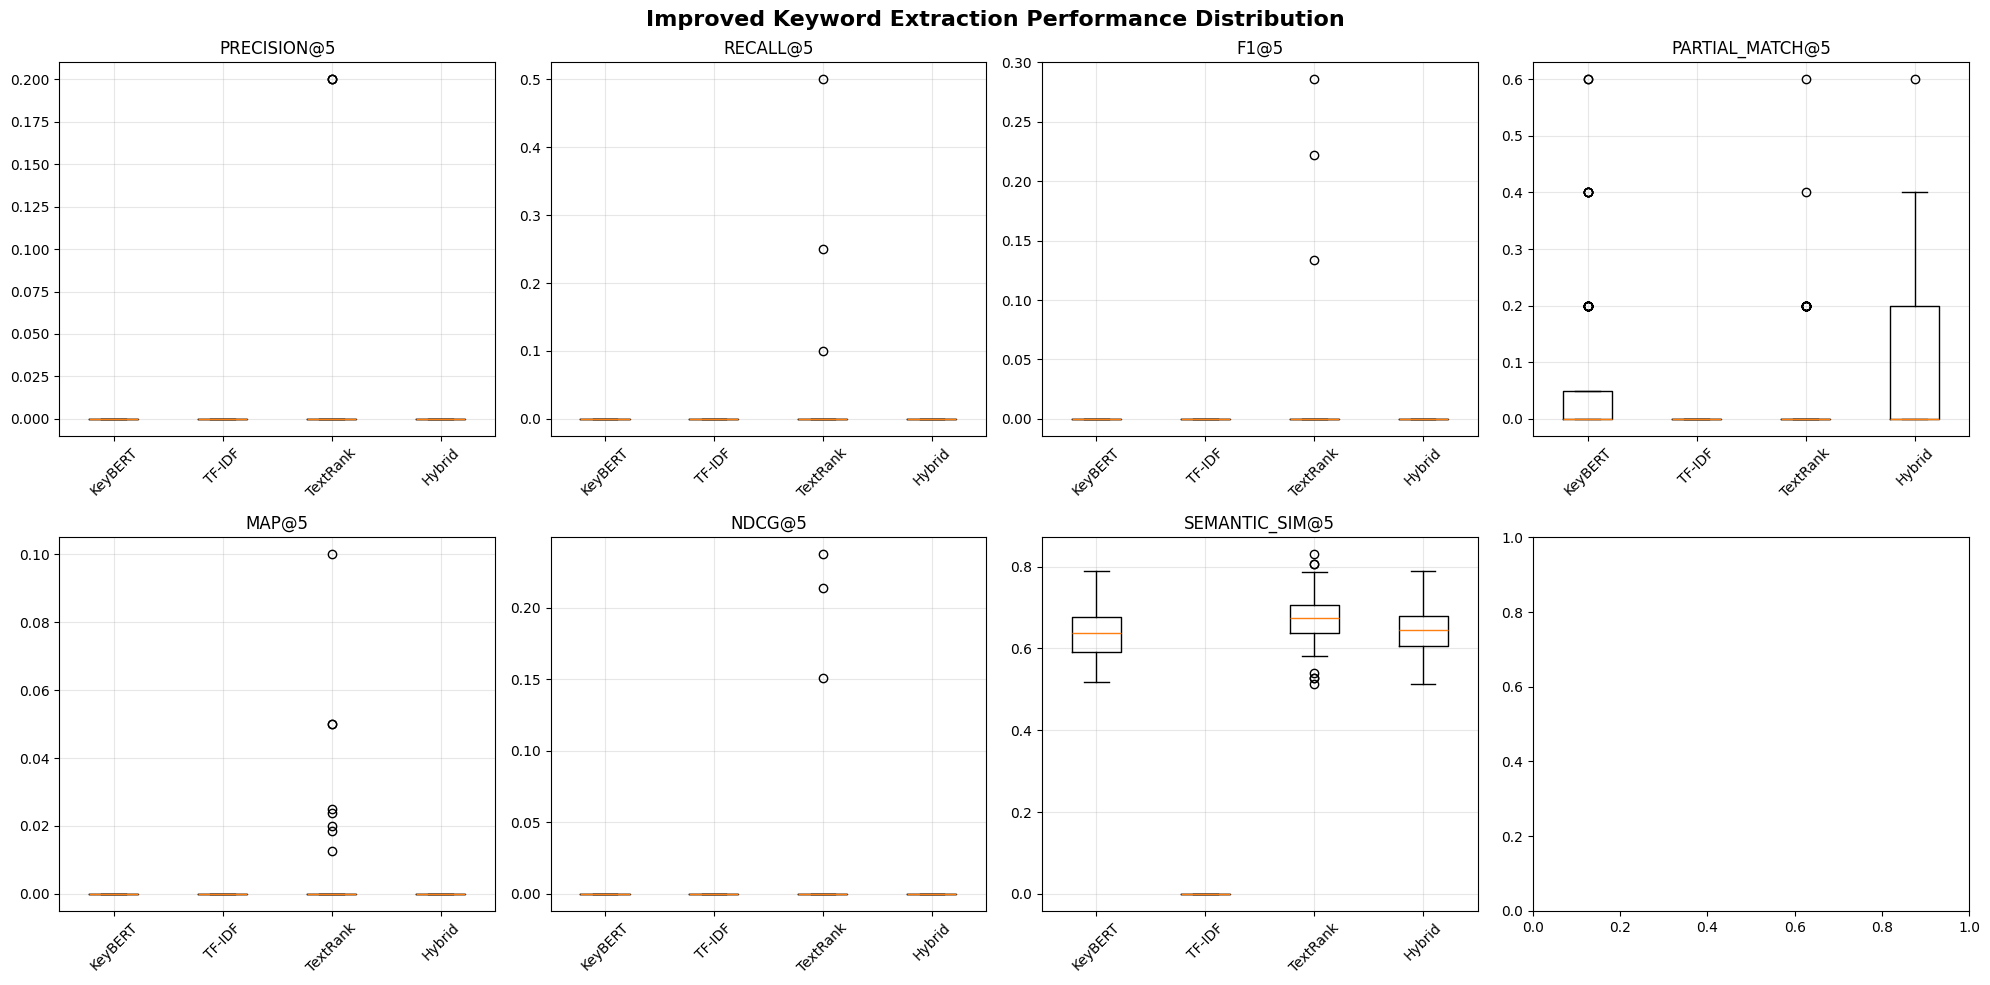

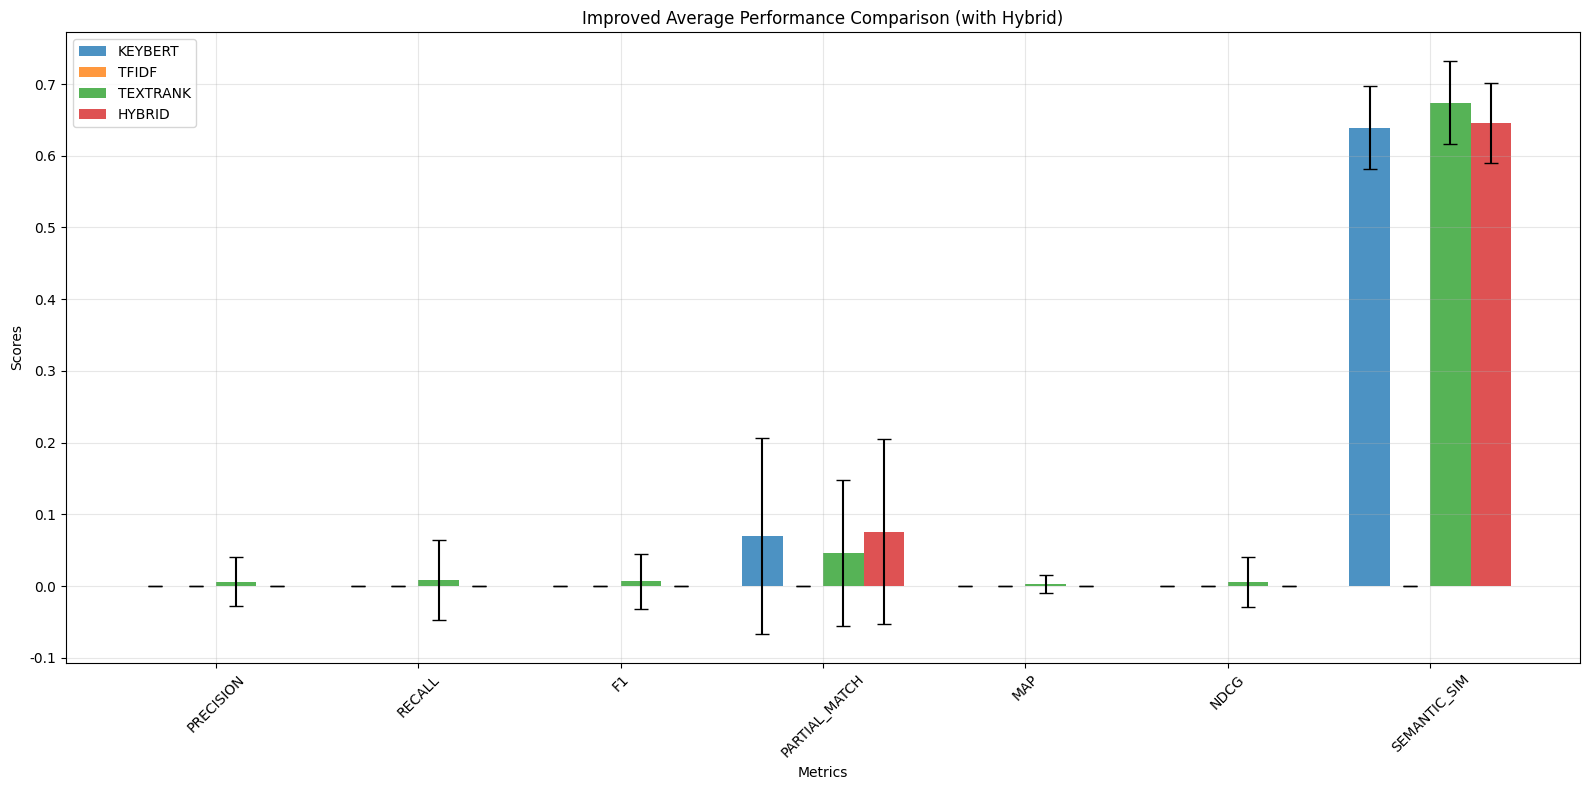

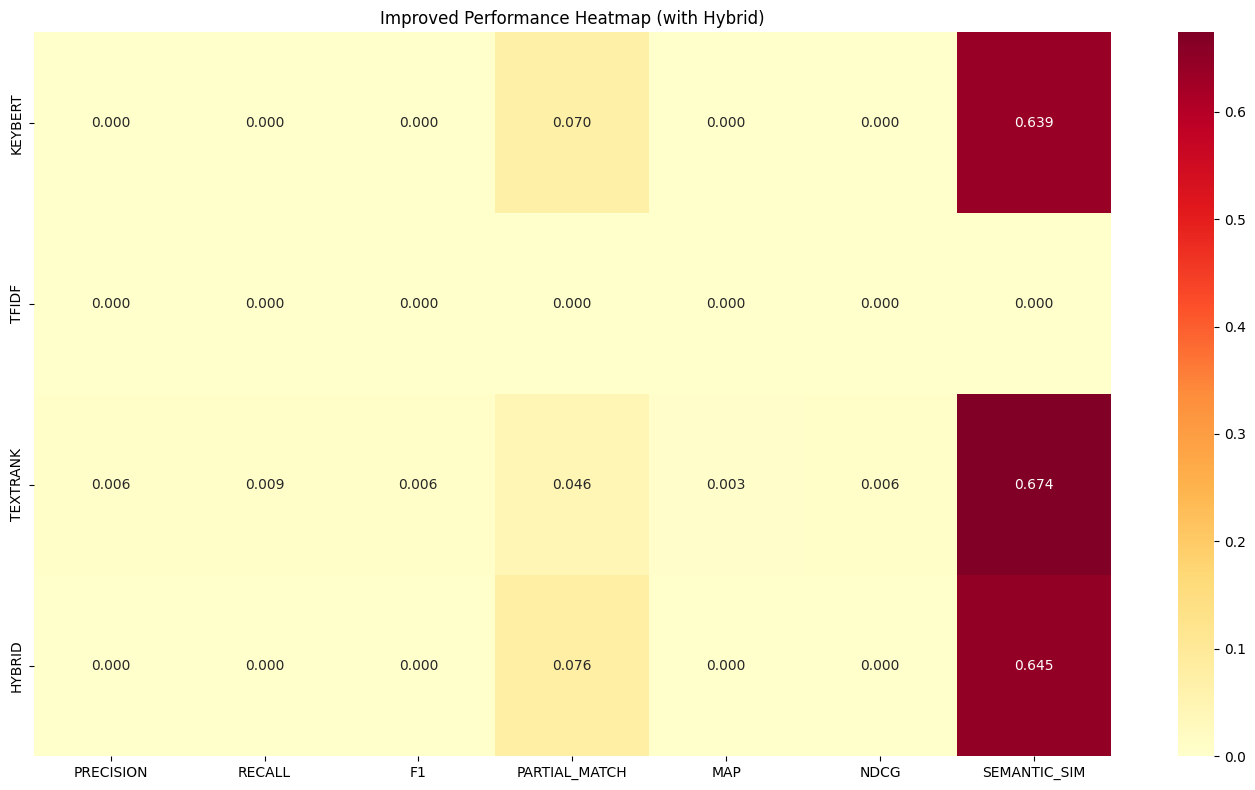

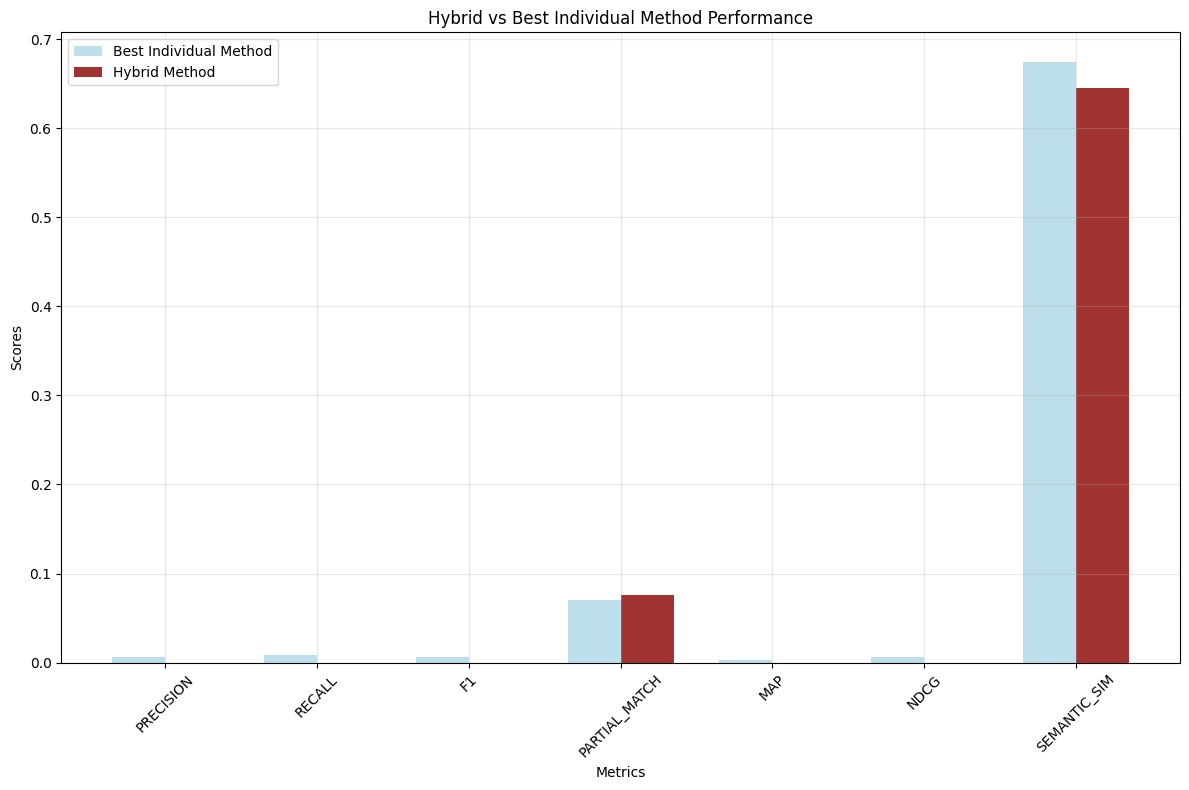

✅ 시각화 완료!

💾 결과 저장 중...
❌ 평가 중 오류 발생: Object of type float32 is not JSON serializable


Traceback (most recent call last):
  File "<ipython-input-10-084fb89beb20>", line 1049, in run_improved_evaluation
    self.save_results()
  File "<ipython-input-10-084fb89beb20>", line 879, in save_results
    json.dump(summary_data, f, ensure_ascii=False, indent=2)
  File "/usr/lib/python3.11/json/__init__.py", line 179, in dump
    for chunk in iterable:
  File "/usr/lib/python3.11/json/encoder.py", line 432, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  [Previous line repeated 1 more time]
  File "/usr/lib/python3.11/json/encoder.py", line 439, in _iterencode
    o = _default(o)
        ^^^^^^^^^^^
  File "/usr/lib/python3.11/json/encoder.py", line 180, in default


In [11]:
evaluator = ImprovedKeywordExtractorComparison(num_samples=100, random_seed=42)
evaluator.run_improved_evaluation()

# 데이터셋 변경

In [25]:
# 영어 기술 문서 키워드 추출 모델 비교 평가 시스템
# ecosystems/keywords 데이터셋 사용

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
import random
import re
from collections import Counter
from tqdm import tqdm
import subprocess
import sys

warnings.filterwarnings('ignore')

def install_requirements():
    """필요한 패키지 설치"""
    packages = [
        #'datasets',
        'keybert',
        'sentence-transformers',
        'networkx',
        'scikit-learn',
        'nltk',
        'scipy'
    ]

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} 설치 완료")
        except:
            print(f"✗ {package} 설치 실패")

# 패키지 설치
print("필요한 패키지 설치 중...")
install_requirements()

필요한 패키지 설치 중...
✓ keybert 설치 완료
✓ sentence-transformers 설치 완료
✓ networkx 설치 완료
✓ scikit-learn 설치 완료
✓ nltk 설치 완료
✓ scipy 설치 완료


In [30]:
# 라이브러리 임포트
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
import networkx as nx
from scipy import stats

# NLTK 데이터 다운로드
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

class TechKeywordExtractorComparison:
    """기술 문서 키워드 추출 비교 평가 클래스"""

    def __init__(self, num_samples=100, random_seed=42):
        self.num_samples = num_samples
        self.random_seed = random_seed

        # 랜덤 시드 설정
        random.seed(random_seed)
        np.random.seed(random_seed)

        # 결과 저장용
        self.results = {}
        self.predictions = {}
        self.references = []
        self.test_texts = []
        self.ecosystems = []

        # 영어 불용어
        try:
            self.english_stopwords = set(stopwords.words('english'))
        except:
            self.english_stopwords = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])

        # 기술 용어 특화 불용어 추가
        tech_stopwords = {
            'library', 'package', 'module', 'framework', 'tool', 'utility', 'client',
            'server', 'api', 'sdk', 'cli', 'gui', 'app', 'application', 'software',
            'code', 'implementation', 'version', 'release', 'update', 'support',
            'simple', 'easy', 'fast', 'lightweight', 'powerful', 'flexible'
        }
        self.english_stopwords.update(tech_stopwords)

        print(f"🚀 기술 문서 키워드 추출 비교 시스템 초기화 (시드: {random_seed})")

    def load_models(self):
        """모든 모델 로드"""
        print("\n📥 모델 로딩 중...")

        # KeyBERT (영어 특화)
        print("  - KeyBERT 로딩...")
        try:
            # 기술 문서에 특화된 모델 사용
            self.keybert = KeyBERT('all-MiniLM-L6-v2')
            print("    ✓ all-MiniLM-L6-v2 모델 사용")
        except:
            self.keybert = KeyBERT('sentence-transformers/all-MiniLM-L6-v2')
            print("    ✓ 기본 영어 모델 사용")

        # 의미적 유사도 계산용
        print("  - Sentence-BERT 로딩...")
        try:
            self.semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
        except:
            self.semantic_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

        # TF-IDF는 나중에 영어 데이터로 학습
        self.tfidf_vectorizer = None

        print("✅ 모델 로딩 완료!")

    def _english_tokenizer(self, text):
        """영어 토크나이저 (기술 용어 특화)"""
        if not text:
            return []

        try:
            # 소문자 변환 및 토큰화
            tokens = word_tokenize(text.lower())

            # POS 태깅으로 명사, 형용사만 추출
            pos_tags = pos_tag(tokens)

            keywords = []
            for word, pos in pos_tags:
                # 명사(NN*), 형용사(JJ*), 고유명사(NNP*) 추출
                if (pos.startswith('NN') or pos.startswith('JJ')) and len(word) >= 2:
                    # 불용어 제거, 알파벳만, 숫자로만 구성된 단어 제외
                    if (word not in self.english_stopwords and
                        word.isalpha() and
                        not word.isdigit()):
                        keywords.append(word)

            return keywords

        except Exception as e:
            # 대체 방법: 정규식 기반
            words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
            return [w for w in words if w not in self.english_stopwords and len(w) >= 2]

    def _preprocess_text(self, text):
        """텍스트 전처리"""
        if not text:
            return ""

        # 특수문자 정리 (하이픈은 유지 - 기술 용어에 중요)
        text = re.sub(r'[^\w\s\-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def _parse_keywords(self, keyword_string):
        """키워드 문자열 파싱"""
        if not keyword_string:
            return []

        # | 구분자로 분리
        keywords = [kw.strip().lower() for kw in keyword_string.split('|') if kw.strip()]

        # 중복 제거 및 필터링
        filtered_keywords = []
        seen = set()
        for kw in keywords:
            if kw and len(kw) >= 2 and kw not in seen:
                # 너무 긴 키워드 제외 (20자 이상)
                if len(kw) <= 20:
                    filtered_keywords.append(kw)
                    seen.add(kw)

        return filtered_keywords

    def _post_process_keywords(self, keywords, top_k=10):
        """키워드 후처리"""
        if not keywords:
            return []

        # 튜플에서 키워드만 추출
        processed = []
        for kw in keywords:
            if isinstance(kw, tuple):
                processed.append(str(kw[0]).lower())
            else:
                processed.append(str(kw).lower())

        # 필터링
        filtered = []
        for kw in processed:
            kw = kw.strip()
            if (2 <= len(kw) <= 20 and
                not kw.isdigit() and
                kw.isalpha() and
                kw not in self.english_stopwords):
                filtered.append(kw)

        # 중복 제거
        seen = set()
        unique_keywords = []
        for kw in filtered:
            if kw not in seen:
                seen.add(kw)
                unique_keywords.append(kw)

        return unique_keywords[:top_k]

    def load_tech_dataset(self):
        """기술 문서 데이터셋 로드"""
        print(f"\n📊 기술 문서 데이터셋 로딩 중...")

        try:
            # ecosystems/keywords 데이터셋 로드
            dataset = load_dataset("ecosystems/keywords")
            train_data = dataset['train']
            print(f"원본 데이터셋 크기: {len(train_data)}")

            # 데이터 품질 확인 및 필터링
            processed_data = []
            ecosystems_count = Counter()

            print("데이터 품질 확인 및 필터링 중...")

            # 더 많은 샘플을 확인하여 품질 좋은 데이터 선별
            sample_size = min(self.num_samples * 10, len(train_data))
            indices = random.sample(range(len(train_data)), sample_size)

            for idx in tqdm(indices, desc="데이터 처리"):
                try:
                    item = train_data[idx]

                    description = item.get('description', '')
                    keywords_str = item.get('keywords', '')
                    ecosystem = item.get('ecosystem', 'unknown')
                    name = item.get('name', '')

                    # 품질 확인
                    if (len(description) >= 20 and  # 최소 길이
                        len(description) <= 1000 and  # 최대 길이
                        keywords_str and  # 키워드 존재
                        '|' in keywords_str):  # 올바른 형태

                        # 키워드 파싱
                        parsed_keywords = self._parse_keywords(keywords_str)

                        # 키워드가 충분한지 확인
                        if len(parsed_keywords) >= 3:
                            processed_data.append({
                                'text': description,
                                'keywords': parsed_keywords,
                                'ecosystem': ecosystem,
                                'name': name,
                                'original_index': idx
                            })

                            ecosystems_count[ecosystem] += 1

                            # 목표 샘플 수에 도달하면 중단
                            if len(processed_data) >= self.num_samples:
                                break

                except Exception as e:
                    continue

            # 최종 데이터 설정
            self.test_data = processed_data[:self.num_samples]
            self.test_texts = [item['text'] for item in self.test_data]
            self.references = [item['keywords'] for item in self.test_data]
            self.ecosystems = [item['ecosystem'] for item in self.test_data]

            print(f"✅ 최종 테스트 데이터: {len(self.test_data)}개")
            print(f"생태계 분포: {dict(ecosystems_count.most_common(5))}")

            # 샘플 출력
            if self.test_data:
                print(f"\n📝 샘플 예시:")
                sample = self.test_data[0]
                print(f"텍스트: {sample['text'][:100]}...")
                print(f"키워드: {sample['keywords'][:5]}")
                print(f"생태계: {sample['ecosystem']}")

        except Exception as e:
            print(f"❌ 데이터 로드 오류: {e}")
            self.test_data = []

    def prepare_english_tfidf(self):
        """영어 TF-IDF 준비"""
        print("\n⚖️ 영어 TF-IDF 준비 중...")

        try:
            # 공정한 비교를 위해 별도의 학습 데이터 사용
            if len(self.test_data) > 50:
                # 테스트 데이터의 일부를 학습용으로 분리
                split_idx = len(self.test_data) // 4
                train_texts = [item['text'] for item in self.test_data[:split_idx]]
                print(f"  TF-IDF 학습 데이터: {len(train_texts)}개")
            else:
                # 데이터가 적으면 전체 사용
                train_texts = self.test_texts
                print(f"  TF-IDF 학습 데이터: {len(train_texts)}개 (전체)")

            # 영어 기술 문서 특화 TF-IDF 벡터라이저
            self.tfidf_vectorizer = TfidfVectorizer(
                tokenizer=self._english_tokenizer,
                ngram_range=(1, 2),  # 1-2 gram
                max_features=5000,
                min_df=1,  # 최소 문서 빈도
                max_df=0.8,  # 최대 문서 빈도
                lowercase=True,
                sublinear_tf=True,  # 로그 스케일링
                stop_words=None  # 커스텀 토크나이저에서 처리
            )

            # 영어 기술 문서로 학습
            self.tfidf_vectorizer.fit(train_texts)
            print("✅ 영어 TF-IDF 학습 완료!")

        except Exception as e:
            print(f"⚠️ TF-IDF 준비 오류: {e}")
            # 최소한의 벡터라이저
            self.tfidf_vectorizer = TfidfVectorizer(
                ngram_range=(1, 1),
                max_features=1000,
                min_df=1,
                stop_words='english'
            )
            basic_texts = ["technical documentation keyword extraction"] * 5
            self.tfidf_vectorizer.fit(basic_texts)
            print("✅ 기본 TF-IDF 학습 완료!")

    def extract_keybert_keywords(self, text, top_k=10):
        """KeyBERT 키워드 추출 (기술 문서 최적화)"""
        try:
            if not text.strip():
                return []

            # 기술 문서에 최적화된 파라미터
            keywords = self.keybert.extract_keywords(
                text,
                keyphrase_ngram_range=(1, 2),  # 1-2 gram
                stop_words='english',
                top_n=top_k * 3,  # 더 많이 추출 후 필터링
                use_mmr=True,  # 다양성 확보
                diversity=0.6,  # 적당한 다양성
                use_maxsum=True,  # 최대합 알고리즘 사용
                nr_candidates=30  # 후보 키워드 수
            )

            keyword_list = [kw[0] for kw in keywords]
            return self._post_process_keywords(keyword_list, top_k)

        except Exception as e:
            print(f"⚠️ KeyBERT 오류: {e}")
            # 대체 방법
            tokens = self._english_tokenizer(text)
            token_counts = Counter(tokens)
            fallback_keywords = [word for word, count in token_counts.most_common(top_k * 2)]
            return self._post_process_keywords(fallback_keywords, top_k)

    def extract_tfidf_keywords(self, text, top_k=10):
        """TF-IDF 키워드 추출"""
        try:
            if not text.strip() or self.tfidf_vectorizer is None:
                return []

            tfidf_vector = self.tfidf_vectorizer.transform([text])
            feature_names = self.tfidf_vectorizer.get_feature_names_out()
            scores = tfidf_vector.toarray()[0]

            # 상위 키워드 추출
            top_indices = scores.argsort()[-(top_k * 3):][::-1]
            keywords = [feature_names[i] for i in top_indices if scores[i] > 0]

            return self._post_process_keywords(keywords, top_k)

        except Exception as e:
            print(f"⚠️ TF-IDF 오류: {e}")
            tokens = self._english_tokenizer(text)
            token_counts = Counter(tokens)
            fallback_keywords = [word for word, count in token_counts.most_common(top_k * 2)]
            return self._post_process_keywords(fallback_keywords, top_k)

    def extract_textrank_keywords(self, text, top_k=10):
        """TextRank 키워드 추출 (기술 문서 최적화)"""
        try:
            if not text.strip():
                return []

            tokens = self._english_tokenizer(text)

            if len(tokens) < 3:
                token_counts = Counter(tokens)
                fallback_keywords = [word for word, count in token_counts.most_common(top_k * 2)]
                return self._post_process_keywords(fallback_keywords, top_k)

            # 그래프 생성
            graph = nx.Graph()

            # 기술 문서에 적합한 윈도우 크기
            window_size = min(6, max(3, len(tokens) // 6))

            for i in range(len(tokens) - window_size + 1):
                window = tokens[i:i + window_size]
                for j in range(len(window)):
                    for k in range(j + 1, len(window)):
                        if window[j] != window[k]:
                            # 거리 기반 가중치
                            distance_weight = 1.0 / (abs(j - k) + 1)

                            if graph.has_edge(window[j], window[k]):
                                graph[window[j]][window[k]]['weight'] += distance_weight
                            else:
                                graph.add_edge(window[j], window[k], weight=distance_weight)

            if len(graph.nodes()) == 0:
                token_counts = Counter(tokens)
                fallback_keywords = [word for word, count in token_counts.most_common(top_k * 2)]
                return self._post_process_keywords(fallback_keywords, top_k)

            # PageRank 실행
            pagerank_scores = nx.pagerank(graph, weight='weight', alpha=0.85, max_iter=100)
            sorted_keywords = sorted(pagerank_scores.items(),
                                   key=lambda x: x[1], reverse=True)

            keywords = [kw[0] for kw in sorted_keywords]
            return self._post_process_keywords(keywords, top_k)

        except Exception as e:
            print(f"⚠️ TextRank 오류: {e}")
            try:
                tokens = self._english_tokenizer(text)
                token_counts = Counter(tokens)
                fallback_keywords = [word for word, count in token_counts.most_common(top_k * 2)]
                return self._post_process_keywords(fallback_keywords, top_k)
            except:
                return []

    def extract_hybrid_keywords(self, text, top_k=10):
        """하이브리드 키워드 추출 (기술 문서 특화)"""
        try:
            if not text.strip():
                return []

            # 각 방법으로 키워드 추출
            keybert_keywords = self.extract_keybert_keywords(text, top_k * 2)
            tfidf_keywords = self.extract_tfidf_keywords(text, top_k * 2)
            textrank_keywords = self.extract_textrank_keywords(text, top_k * 2)

            # 키워드 점수 계산
            keyword_scores = {}

            # KeyBERT 점수 (의미적 중요도) - 가중치 높음
            for i, kw in enumerate(keybert_keywords):
                score = (len(keybert_keywords) - i) / len(keybert_keywords) if keybert_keywords else 0
                keyword_scores[kw] = keyword_scores.get(kw, 0) + score * 0.5

            # TF-IDF 점수 (통계적 중요도)
            for i, kw in enumerate(tfidf_keywords):
                score = (len(tfidf_keywords) - i) / len(tfidf_keywords) if tfidf_keywords else 0
                keyword_scores[kw] = keyword_scores.get(kw, 0) + score * 0.3

            # TextRank 점수 (구조적 중요도)
            for i, kw in enumerate(textrank_keywords):
                score = (len(textrank_keywords) - i) / len(textrank_keywords) if textrank_keywords else 0
                keyword_scores[kw] = keyword_scores.get(kw, 0) + score * 0.2

            # 공통 키워드 보너스
            all_keywords = set(keybert_keywords + tfidf_keywords + textrank_keywords)
            for kw in all_keywords:
                methods_count = sum([
                    kw in keybert_keywords,
                    kw in tfidf_keywords,
                    kw in textrank_keywords
                ])
                if methods_count >= 2:
                    keyword_scores[kw] = keyword_scores.get(kw, 0) + 0.3 * (methods_count - 1)

            # 점수 기반 정렬
            if keyword_scores:
                sorted_keywords = sorted(keyword_scores.items(),
                                       key=lambda x: x[1], reverse=True)
                hybrid_keywords = [kw[0] for kw in sorted_keywords]
                return self._post_process_keywords(hybrid_keywords, top_k)
            else:
                return []

        except Exception as e:
            print(f"⚠️ Hybrid 오류: {e}")
            return self.extract_keybert_keywords(text, top_k)

    def extract_all_keywords(self):
        """모든 방법으로 키워드 추출"""
        print(f"\n🔄 키워드 추출 시작 ({len(self.test_data)}개 샘플)...")

        keybert_predictions = []
        tfidf_predictions = []
        textrank_predictions = []
        hybrid_predictions = []

        for i, item in enumerate(tqdm(self.test_data, desc="키워드 추출")):
            text = item['text']

            # 텍스트 전처리
            clean_text = self._preprocess_text(text)

            # 각 방법으로 키워드 추출
            keybert_kw = self.extract_keybert_keywords(clean_text, top_k=10)
            tfidf_kw = self.extract_tfidf_keywords(clean_text, top_k=10)
            textrank_kw = self.extract_textrank_keywords(clean_text, top_k=10)
            hybrid_kw = self.extract_hybrid_keywords(clean_text, top_k=10)

            keybert_predictions.append(keybert_kw)
            tfidf_predictions.append(tfidf_kw)
            textrank_predictions.append(textrank_kw)
            hybrid_predictions.append(hybrid_kw)

            # 진행상황 출력 (10개마다)
            if (i + 1) % 20 == 0:
                print(f"\n--- 샘플 {i+1} ---")
                print(f"텍스트: {text[:80]}...")
                print(f"참조: {item['keywords'][:3]}")
                print(f"KeyBERT: {keybert_kw[:3]}")
                print(f"TF-IDF: {tfidf_kw[:3]}")
                print(f"TextRank: {textrank_kw[:3]}")
                print(f"Hybrid: {hybrid_kw[:3]}")

        # 결과 저장
        self.predictions = {
            'keybert': keybert_predictions,
            'tfidf': tfidf_predictions,
            'textrank': textrank_predictions,
            'hybrid': hybrid_predictions
        }

        print("✅ 키워드 추출 완료!")

    def calculate_precision_recall_f1(self, predicted, true, k=5):
        """Precision@K, Recall@K, F1@K 계산"""
        pred_k = set([kw.lower().strip() for kw in predicted[:k] if kw])
        true_set = set([kw.lower().strip() for kw in true if kw])

        if len(true_set) == 0 or len(pred_k) == 0:
            return {"precision": 0, "recall": 0, "f1": 0}

        intersection = pred_k.intersection(true_set)

        precision = len(intersection) / len(pred_k) if len(pred_k) > 0 else 0
        recall = len(intersection) / len(true_set)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        return {"precision": precision, "recall": recall, "f1": f1}

    def calculate_partial_match_score(self, predicted, true, k=5):
        """부분 매칭 점수 계산 (기술 용어 특화)"""
        pred_k = [kw.lower().strip() for kw in predicted[:k] if kw]
        true_list = [kw.lower().strip() for kw in true if kw]

        if len(true_list) == 0 or len(pred_k) == 0:
            return 0

        matches = 0
        for pred in pred_k:
            for true_kw in true_list:
                if (pred == true_kw or
                    pred in true_kw or
                    true_kw in pred or
                    self._tech_fuzzy_match(pred, true_kw)):
                    matches += 1
                    break

        return matches / len(pred_k) if len(pred_k) > 0 else 0

    def _tech_fuzzy_match(self, str1, str2, threshold=0.8):
        """기술 용어 특화 유사 매칭"""
        if len(str1) < 2 or len(str2) < 2:
            return False

        # 하이픈 제거 후 비교 (예: "machine-learning" vs "machinelearning")
        clean1 = str1.replace('-', '').replace('_', '')
        clean2 = str2.replace('-', '').replace('_', '')

        if clean1 == clean2:
            return True

        # 문자 집합 유사도
        set1 = set(clean1)
        set2 = set(clean2)
        intersection = len(set1 & set2)
        union = len(set1 | set2)

        return (intersection / union) > threshold if union > 0 else False

    def calculate_semantic_similarity(self, predicted, true, k=5):
        """의미적 유사도 계산"""
        pred_k = [kw for kw in predicted[:k] if kw.strip()]
        true_list = [kw for kw in true if kw.strip()]

        if len(true_list) == 0 or len(pred_k) == 0:
            return 0

        try:
            pred_embeddings = self.semantic_model.encode(pred_k)
            true_embeddings = self.semantic_model.encode(true_list)

            similarities = cosine_similarity(pred_embeddings, true_embeddings)
            max_similarities = np.max(similarities, axis=1)

            # 임계값 이상의 유사도만 인정
            threshold = 0.6
            valid_similarities = max_similarities[max_similarities > threshold]

            return np.mean(valid_similarities) if len(valid_similarities) > 0 else 0

        except Exception as e:
            print(f"⚠️ 의미적 유사도 계산 오류: {e}")
            return 0

    def calculate_ndcg_score(self, predicted, true, k=5):
        """NDCG@K 점수 계산"""
        pred_k = [kw.lower().strip() for kw in predicted[:k] if kw]
        true_set = set([kw.lower().strip() for kw in true if kw])

        if len(true_set) == 0 or len(pred_k) == 0:
            return 0

        # 관련성 점수 계산 (정확히 일치하면 1, 부분 일치하면 0.5)
        relevance_scores = []
        for pred in pred_k:
            if pred in true_set:
                relevance_scores.append(1.0)
            elif any(pred in true_kw or true_kw in pred for true_kw in true_set):
                relevance_scores.append(0.5)
            else:
                relevance_scores.append(0.0)

        # DCG 계산
        dcg = relevance_scores[0] if relevance_scores else 0
        for i in range(1, len(relevance_scores)):
            dcg += relevance_scores[i] / np.log2(i + 1)

        # IDCG 계산 (이상적인 순서)
        ideal_scores = sorted([1.0] * min(len(true_set), k), reverse=True)
        idcg = ideal_scores[0] if ideal_scores else 0
        for i in range(1, len(ideal_scores)):
            idcg += ideal_scores[i] / np.log2(i + 1)

        return dcg / idcg if idcg > 0 else 0

    def calculate_all_metrics(self):
        """모든 평가 지표 계산"""
        print("\n📊 평가 지표 계산 중...")

        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'semantic_sim', 'ndcg']

        self.results = {}

        for method in methods:
            print(f"  - {method.upper()} 평가 중...")

            self.results[method] = {metric: [] for metric in metrics}
            predictions = self.predictions[method]

            for pred, true in zip(predictions, self.references):
                # 기본 지표 (K=5)
                basic_metrics = self.calculate_precision_recall_f1(pred, true, k=5)
                self.results[method]['precision'].append(basic_metrics['precision'])
                self.results[method]['recall'].append(basic_metrics['recall'])
                self.results[method]['f1'].append(basic_metrics['f1'])

                # 부분 매칭
                partial_score = self.calculate_partial_match_score(pred, true, k=5)
                self.results[method]['partial_match'].append(partial_score)

                # 의미적 유사도
                sem_sim = self.calculate_semantic_similarity(pred, true, k=5)
                self.results[method]['semantic_sim'].append(sem_sim)

                # NDCG
                ndcg_score = self.calculate_ndcg_score(pred, true, k=5)
                self.results[method]['ndcg'].append(ndcg_score)

        print("✅ 모든 평가 지표 계산 완료!")

    def statistical_analysis(self):
        """통계적 유의성 검정"""
        print("\n📈 통계적 유의성 검정 중...")

        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'semantic_sim', 'ndcg']

        self.stat_results = {}

        # 모든 방법 쌍에 대해 검정
        for metric in metrics:
            self.stat_results[metric] = {}

            for i, method1 in enumerate(methods):
                for j, method2 in enumerate(methods):
                    if i < j:  # 중복 방지
                        scores1 = self.results[method1][metric]
                        scores2 = self.results[method2][metric]

                        # Paired t-test
                        t_stat, t_pvalue = stats.ttest_rel(scores1, scores2)

                        # Wilcoxon signed-rank test
                        try:
                            w_stat, w_pvalue = stats.wilcoxon(scores1, scores2)
                        except:
                            w_stat, w_pvalue = 0, 1.0

                        # 효과 크기 (Cohen's d)
                        pooled_std = np.sqrt((np.var(scores1) + np.var(scores2)) / 2)
                        cohens_d = (np.mean(scores1) - np.mean(scores2)) / pooled_std if pooled_std > 0 else 0

                        comparison_key = f"{method1}_vs_{method2}"
                        self.stat_results[metric][comparison_key] = {
                            't_statistic': t_stat,
                            't_pvalue': t_pvalue,
                            'wilcoxon_statistic': w_stat,
                            'wilcoxon_pvalue': w_pvalue,
                            'cohens_d': cohens_d,
                            'mean_diff': np.mean(scores1) - np.mean(scores2)
                        }

        print("✅ 통계적 분석 완료!")

    def create_visualizations(self):
        """결과 시각화 (수정된 버전)"""
        print("\n🎨 시각화 생성 중...")

        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False

        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'semantic_sim', 'ndcg']

        # 1. 박스플롯 - 분포 비교 (수정된 버전)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Technical Document Keyword Extraction Performance Distribution',
                    fontsize=16, fontweight='bold')

        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

        for i, metric in enumerate(metrics):
            row = i // 3
            col = i % 3

            data_to_plot = [self.results[method][metric] for method in methods]

            # 박스플롯 생성 (색상 설정 제거)
            bp = axes[row, col].boxplot(data_to_plot, labels=['KeyBERT', 'TF-IDF', 'TextRank', 'Hybrid'],
                                      patch_artist=True)  # patch_artist=True 추가
            axes[row, col].set_title(f'{metric.upper()}@5')
            axes[row, col].grid(True, alpha=0.3)
            axes[row, col].tick_params(axis='x', rotation=45)

            # 안전한 색상 설정
            try:
                for patch, color in zip(bp['boxes'], colors):
                    if hasattr(patch, 'set_facecolor'):
                        patch.set_facecolor(color)
            except Exception as e:
                print(f"⚠️ 박스플롯 색상 설정 건너뜀: {e}")

        plt.tight_layout()
        plt.savefig('tech_keyword_extraction_boxplot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 2. 평균 성능 비교 바 차트 (기존과 동일)
        fig, ax = plt.subplots(figsize=(15, 8))

        x = np.arange(len(metrics))
        width = 0.2
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

        for i, method in enumerate(methods):
            means = [np.mean(self.results[method][metric]) for metric in metrics]
            stds = [np.std(self.results[method][metric]) for metric in metrics]

            bars = ax.bar(x + i*width, means, width, yerr=stds,
                        label=method.upper(), alpha=0.8, capsize=5, color=colors[i])

            # 값 표시
            for j, (mean, std) in enumerate(zip(means, stds)):
                ax.text(x[j] + i*width, mean + std + 0.01, f'{mean:.3f}',
                      ha='center', va='bottom', fontsize=8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Scores')
        ax.set_title('Technical Document Keyword Extraction Performance Comparison')
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels([m.upper().replace('_', ' ') for m in metrics])
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, max([max([np.mean(self.results[m][metric]) + np.std(self.results[m][metric])
                                for m in methods]) for metric in metrics]) * 1.1)

        plt.tight_layout()
        plt.savefig('tech_keyword_extraction_barplot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 3. 히트맵 - 성능 매트릭스 (기존과 동일)
        heatmap_data = []
        for method in methods:
            row = [np.mean(self.results[method][metric]) for metric in metrics]
            heatmap_data.append(row)

        fig, ax = plt.subplots(figsize=(12, 8))
        im = sns.heatmap(heatmap_data,
                        xticklabels=[m.upper().replace('_', ' ') for m in metrics],
                        yticklabels=[m.upper() for m in methods],
                        annot=True, fmt='.3f', cmap='YlOrRd',
                        ax=ax, cbar_kws={'label': 'Score'})
        ax.set_title('Technical Document Keyword Extraction Performance Heatmap')
        plt.tight_layout()
        plt.savefig('tech_keyword_extraction_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 4. 생태계별 성능 분석 (기존과 동일)
        if len(set(self.ecosystems)) > 1:
            ecosystem_performance = {}
            unique_ecosystems = list(set(self.ecosystems))[:5]  # 상위 5개만

            for ecosystem in unique_ecosystems:
                ecosystem_indices = [i for i, eco in enumerate(self.ecosystems) if eco == ecosystem]
                if len(ecosystem_indices) >= 5:  # 충분한 샘플이 있는 경우만
                    ecosystem_performance[ecosystem] = {}
                    for method in methods:
                        f1_scores = [self.results[method]['f1'][i] for i in ecosystem_indices]
                        ecosystem_performance[ecosystem][method] = np.mean(f1_scores)

            if ecosystem_performance:
                fig, ax = plt.subplots(figsize=(12, 6))

                ecosystems = list(ecosystem_performance.keys())
                x = np.arange(len(ecosystems))
                width = 0.2

                for i, method in enumerate(methods):
                    means = [ecosystem_performance[eco][method] for eco in ecosystems]
                    ax.bar(x + i*width, means, width, label=method.upper(),
                          alpha=0.8, color=colors[i])

                ax.set_xlabel('Ecosystem')
                ax.set_ylabel('F1@5 Score')
                ax.set_title('Keyword Extraction Performance by Ecosystem')
                ax.set_xticks(x + width * 1.5)
                ax.set_xticklabels(ecosystems, rotation=45)
                ax.legend()
                ax.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.savefig('tech_keyword_extraction_ecosystem.png', dpi=300, bbox_inches='tight')
                plt.show()

        print("✅ 시각화 완료!")

    def save_results(self):
        """결과 저장"""
        print("\n💾 결과 저장 중...")

        # 상세 결과 CSV
        detailed_results = []
        for i in range(len(self.references)):
            row = {
                'sample_id': i,
                'text': self.test_texts[i][:200] + "..." if len(self.test_texts[i]) > 200 else self.test_texts[i],
                'ecosystem': self.ecosystems[i],
                'true_keywords': '; '.join(self.references[i][:10])
            }

            for method in ['keybert', 'tfidf', 'textrank', 'hybrid']:
                row[f'{method}_keywords'] = '; '.join(self.predictions[method][i][:5])

                for metric in ['precision', 'recall', 'f1', 'partial_match', 'semantic_sim', 'ndcg']:
                    row[f'{method}_{metric}'] = self.results[method][metric][i]

            detailed_results.append(row)

        df = pd.DataFrame(detailed_results)
        df.to_csv('tech_keyword_extraction_results.csv', index=False, encoding='utf-8-sig')

        # 요약 결과 JSON
        summary_data = {
            'experiment_info': {
                'num_samples': self.num_samples,
                'random_seed': self.random_seed,
                'evaluation_date': datetime.now().isoformat(),
                'dataset': 'ecosystems/keywords',
                'language': 'English',
                'domain': 'Technical Documentation',
                'methods': ['KeyBERT', 'TF-IDF', 'TextRank', 'Hybrid']
            },
            'performance_summary': {},
            'statistical_results': self.stat_results,
            'ecosystem_distribution': dict(Counter(self.ecosystems).most_common(10)),
            'sample_predictions': {
                'keybert': self.predictions['keybert'][:3],
                'tfidf': self.predictions['tfidf'][:3],
                'textrank': self.predictions['textrank'][:3],
                'hybrid': self.predictions['hybrid'][:3],
                'references': self.references[:3],
                'texts': self.test_texts[:3]
            }
        }

        # 성능 요약 계산
        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'semantic_sim', 'ndcg']

        for method in methods:
            summary_data['performance_summary'][method] = {}
            for metric in metrics:
                scores = self.results[method][metric]
                summary_data['performance_summary'][method][metric] = {
                    'mean': float(np.mean(scores)),
                    'std': float(np.std(scores)),
                    'median': float(np.median(scores)),
                    'min': float(np.min(scores)),
                    'max': float(np.max(scores))
                }

        with open('tech_keyword_extraction_summary.json', 'w', encoding='utf-8') as f:
            json.dump(summary_data, f, ensure_ascii=False, indent=2)

        print("✅ 결과 저장 완료!")
        print("  - tech_keyword_extraction_results.csv: 상세 결과")
        print("  - tech_keyword_extraction_summary.json: 통계 요약")

    def generate_report(self):
        """종합 보고서 생성"""
        print("\n📋 종합 보고서 생성 중...")

        methods = ['keybert', 'tfidf', 'textrank', 'hybrid']
        metrics = ['precision', 'recall', 'f1', 'partial_match', 'semantic_sim', 'ndcg']

        report = []
        report.append("=" * 80)
        report.append("기술 문서 키워드 추출 모델 비교 평가 보고서")
        report.append("데이터셋: ecosystems/keywords")
        report.append("=" * 80)
        report.append(f"평가 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"평가 샘플 수: {self.num_samples}")
        report.append(f"언어: 영어")
        report.append(f"도메인: 기술 문서")
        report.append(f"생태계 분포: {dict(Counter(self.ecosystems).most_common(5))}")
        report.append("")

        # 성능 요약
        report.append("📊 성능 요약 (평균 ± 표준편차)")
        report.append("-" * 60)

        for metric in metrics:
            report.append(f"\n{metric.upper().replace('_', ' ')}@5:")
            for method in methods:
                mean_score = np.mean(self.results[method][metric])
                std_score = np.std(self.results[method][metric])
                report.append(f"  {method.upper():>10}: {mean_score:.4f} ± {std_score:.4f}")

        report.append("")

        # 최고 성능 방법
        report.append("🏆 최고 성능 방법")
        report.append("-" * 40)

        wins = {method: 0 for method in methods}
        for metric in metrics:
            best_method = max(methods, key=lambda m: np.mean(self.results[m][metric]))
            best_score = np.mean(self.results[best_method][metric])
            report.append(f"{metric.upper().replace('_', ' '):>15}: {best_method.upper()} ({best_score:.4f})")
            wins[best_method] += 1

        report.append("")

        # 전체 승수 및 결론
        best_overall = max(wins, key=wins.get)
        report.append("🎯 종합 결론")
        report.append("-" * 40)
        report.append(f"• 전반적 최고 성능: {best_overall.upper()} ({wins[best_overall]}/{len(metrics)} 지표에서 1위)")

        # 통계적 유의성 요약
        significant_comparisons = []
        for metric in metrics:
            for comparison, stats_data in self.stat_results[metric].items():
                if stats_data['t_pvalue'] < 0.05:
                    method1, method2 = comparison.split('_vs_')
                    significant_comparisons.append(f"{method1.upper()} vs {method2.upper()} in {metric.upper()}")

        if significant_comparisons:
            report.append(f"• 통계적으로 유의미한 차이: {len(significant_comparisons)}개 비교")
        else:
            report.append("• 통계적으로 유의미한 차이 없음")

        # 실용적 권장사항
        report.append("")
        report.append("💡 실용적 권장사항")
        report.append("-" * 40)

        # F1 점수 기준으로 권장사항 생성
        f1_means = {method: np.mean(self.results[method]['f1']) for method in methods}
        semantic_means = {method: np.mean(self.results[method]['semantic_sim']) for method in methods}

        best_f1 = max(f1_means, key=f1_means.get)
        best_semantic = max(semantic_means, key=semantic_means.get)

        report.append(f"• 전반적 성능: {best_f1.upper()} 추천 (F1@5: {f1_means[best_f1]:.3f})")
        report.append(f"• 의미적 정확성: {best_semantic.upper()} 추천 (Semantic Sim: {semantic_means[best_semantic]:.3f})")
        report.append("• 기술 문서에서는 의미적 유사도가 중요한 평가 기준")
        report.append("• 도메인별 특성을 고려한 후처리 필요")
        report.append("• 하이브리드 방법으로 안정적인 성능 확보 가능")

        # 한계점 및 개선 방향
        report.append("")
        report.append("⚠️ 한계점 및 개선 방향")
        report.append("-" * 40)
        report.append("• 짧은 기술 문서에서는 문맥 정보 부족")
        report.append("• 도메인 특화 용어에 대한 추가 학습 필요")
        report.append("• 인간 평가와의 상관관계 분석 필요")
        report.append("• 실시간 성능 최적화 고려")

        report.append("")
        report.append("=" * 80)

        # 보고서 저장 및 출력
        with open('tech_keyword_extraction_report.txt', 'w', encoding='utf-8') as f:
            f.write('\n'.join(report))

        for line in report:
            print(line)

        print("\n✅ 보고서 생성 완료! (tech_keyword_extraction_report.txt)")

    def run_tech_evaluation(self):
        """기술 문서 키워드 추출 평가 전체 프로세스 실행"""
        print("🚀 기술 문서 키워드 추출 모델 비교 평가 시작!")
        print("=" * 60)

        try:
            # 1. 모델 로드
            self.load_models()

            # 2. 기술 문서 데이터셋 로드
            self.load_tech_dataset()

            if not self.test_data:
                print("❌ 테스트 데이터가 없습니다.")
                return

            # 3. 영어 TF-IDF 준비
            self.prepare_english_tfidf()

            # 4. 키워드 추출
            self.extract_all_keywords()

            # 5. 평가 지표 계산
            self.calculate_all_metrics()

            # 6. 통계적 분석
            self.statistical_analysis()

            # 7. 시각화
            self.create_visualizations()

            # 8. 결과 저장
            self.save_results()

            # 9. 보고서 생성
            self.generate_report()

            print("\n🎉 기술 문서 키워드 추출 평가 완료!")
            print("생성된 파일들:")
            print("  - tech_keyword_extraction_results.csv")
            print("  - tech_keyword_extraction_summary.json")
            print("  - tech_keyword_extraction_report.txt")
            print("  - tech_keyword_extraction_*.png")

        except Exception as e:
            print(f"❌ 평가 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()



🚀 기술 문서 키워드 추출 비교 시스템 초기화 (시드: 42)
🚀 기술 문서 키워드 추출 모델 비교 평가 시작!

📥 모델 로딩 중...
  - KeyBERT 로딩...
    ✓ all-MiniLM-L6-v2 모델 사용
  - Sentence-BERT 로딩...
✅ 모델 로딩 완료!

📊 기술 문서 데이터셋 로딩 중...
원본 데이터셋 크기: 2891575
데이터 품질 확인 및 필터링 중...


데이터 처리:  16%|█▌        | 162/1000 [00:00<00:00, 10334.25it/s]


✅ 최종 테스트 데이터: 100개
생태계 분포: {'npm': 56, 'nuget': 10, 'maven': 9, 'packagist': 8, 'pypi': 8}

📝 샘플 예시:
텍스트: This package is a single spa parcel microfrontend to see account team members...
키워드: ['thoughtworks', 'mytw', 'techops', 'internal']
생태계: npm

⚖️ 영어 TF-IDF 준비 중...
  TF-IDF 학습 데이터: 25개
✅ 영어 TF-IDF 학습 완료!

🔄 키워드 추출 시작 (100개 샘플)...


키워드 추출:  24%|██▍       | 24/100 [00:01<00:03, 20.44it/s]


--- 샘플 20 ---
텍스트:  Apache Tika is a toolkit for detecting and extracting metadata and structured t...
참조: ['content', 'extraction', 'java']
KeyBERT: ['parser', 'metadata', 'tika']
TF-IDF: ['using', 'text', 'toolkit']
TextRank: ['toolkit', 'existing', 'using']
Hybrid: ['toolkit', 'metadata', 'extracting']


키워드 추출:  42%|████▏     | 42/100 [00:02<00:02, 19.45it/s]


--- 샘플 40 ---
텍스트: Utility to encode and decode italian TIN (Codice Fiscale)....
참조: ['tin', 'italian', 'codice']
KeyBERT: ['fiscale', 'encode', 'decode']
TF-IDF: []
TextRank: ['italian', 'tin', 'decode']
Hybrid: ['fiscale', 'encode', 'decode']


키워드 추출:  62%|██████▏   | 62/100 [00:03<00:01, 19.05it/s]


--- 샘플 60 ---
텍스트: wechat mini program canvas draw tool....
참조: ['wechat', 'mini-program', 'canvas']
KeyBERT: ['canvas', 'wechat', 'draw']
TF-IDF: []
TextRank: ['program', 'mini', 'canvas']
Hybrid: ['canvas', 'wechat', 'program']


키워드 추출:  82%|████████▏ | 82/100 [00:04<00:00, 18.26it/s]


--- 샘플 80 ---
텍스트: OpenAPI client for Veeroute Stock...
참조: ['openapi-client', 'lss', 'logistics']
KeyBERT: ['openapi', 'veeroute', 'stock']
TF-IDF: []
TextRank: ['veeroute', 'openapi', 'stock']
Hybrid: ['openapi', 'veeroute', 'stock']


키워드 추출: 100%|██████████| 100/100 [00:05<00:00, 18.16it/s]



--- 샘플 100 ---
텍스트: [![CircleCI](https://circleci.com/gh/tameemsafi/typewriterjs.svg?style=svg)](htt...
참조: ['typewriter', 'typewriter effect', 'es6']
KeyBERT: ['svg', 'circleci', 'typewriterjs']
TF-IDF: []
TextRank: ['circleci', 'gh', 'com']
Hybrid: ['circleci', 'svg', 'typewriterjs']
✅ 키워드 추출 완료!

📊 평가 지표 계산 중...
  - KEYBERT 평가 중...
  - TFIDF 평가 중...
  - TEXTRANK 평가 중...
  - HYBRID 평가 중...
✅ 모든 평가 지표 계산 완료!

📈 통계적 유의성 검정 중...
✅ 통계적 분석 완료!

🎨 시각화 생성 중...


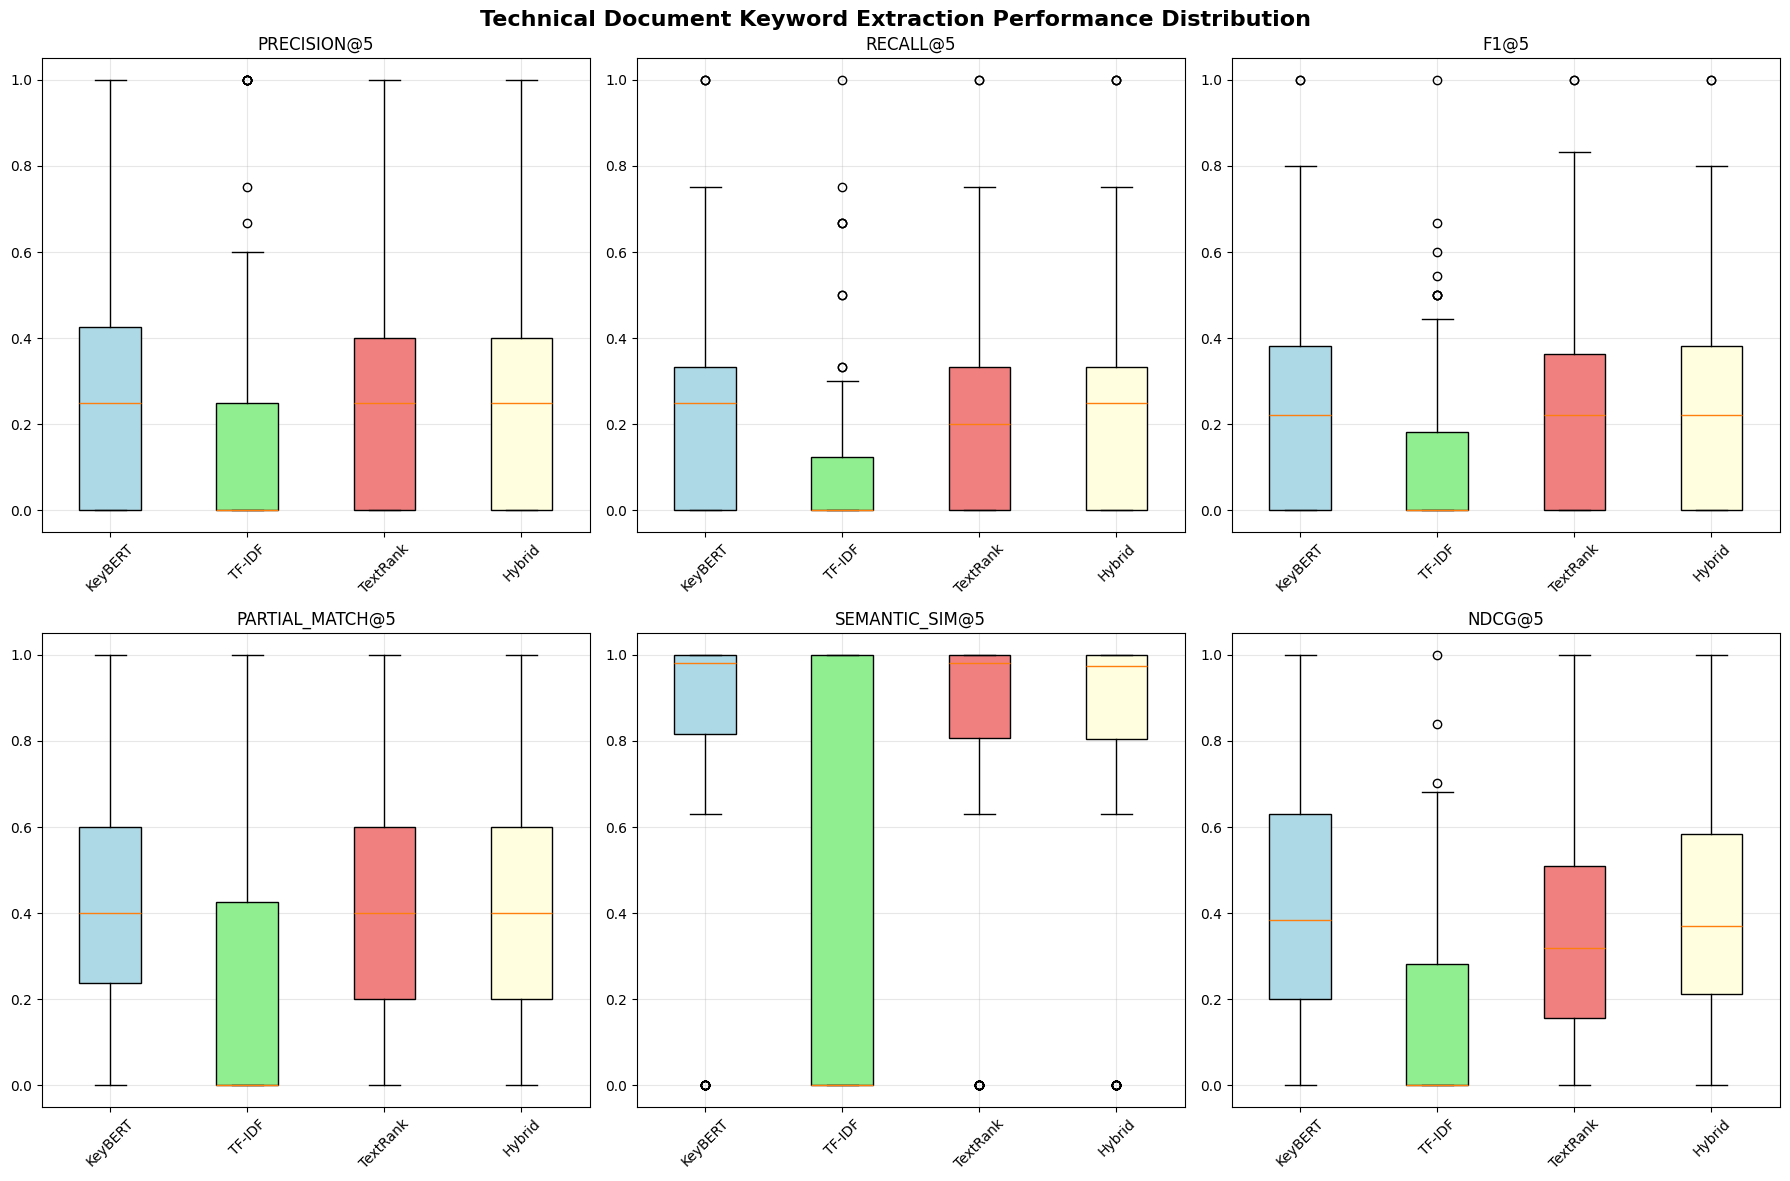

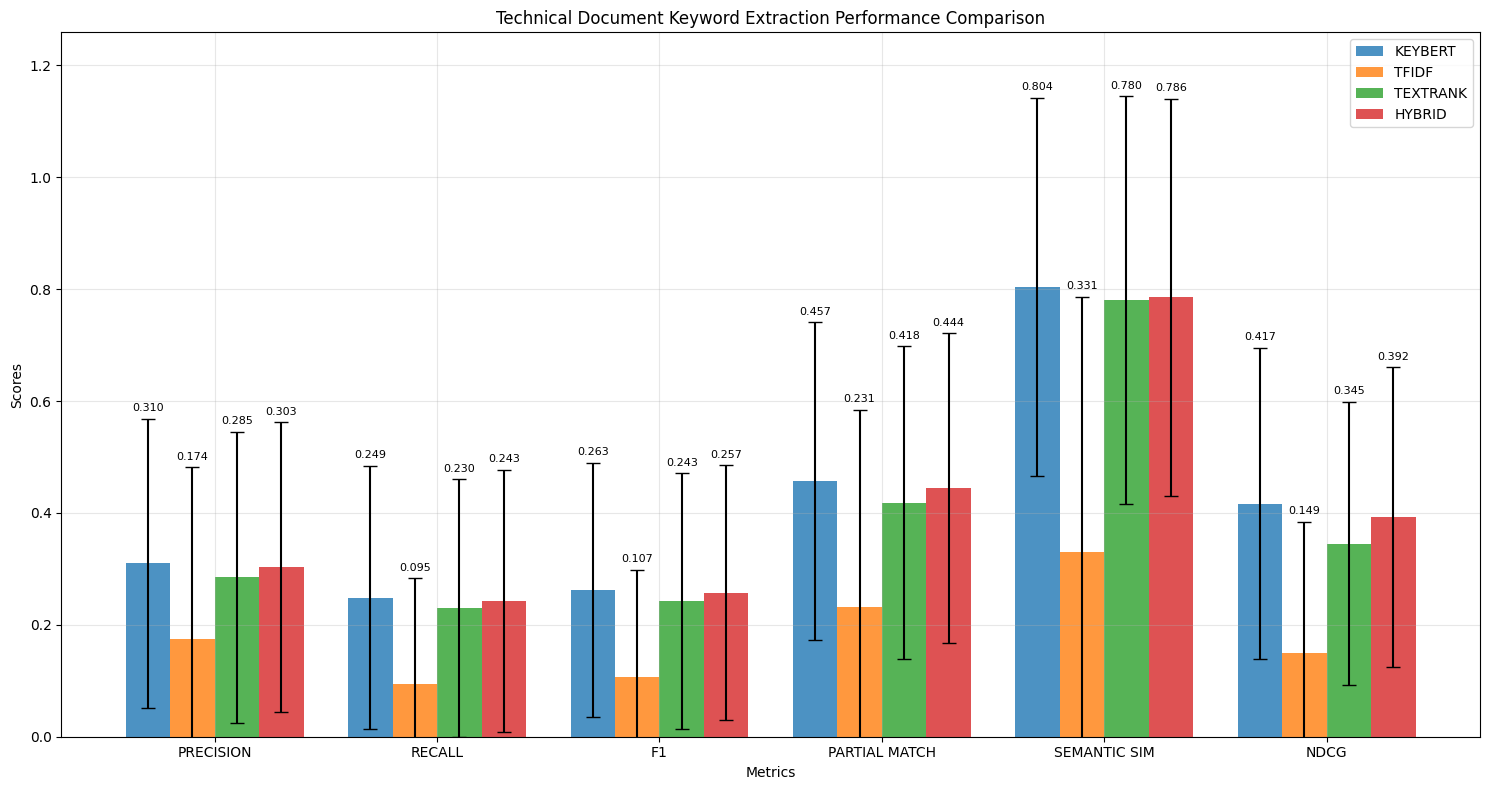

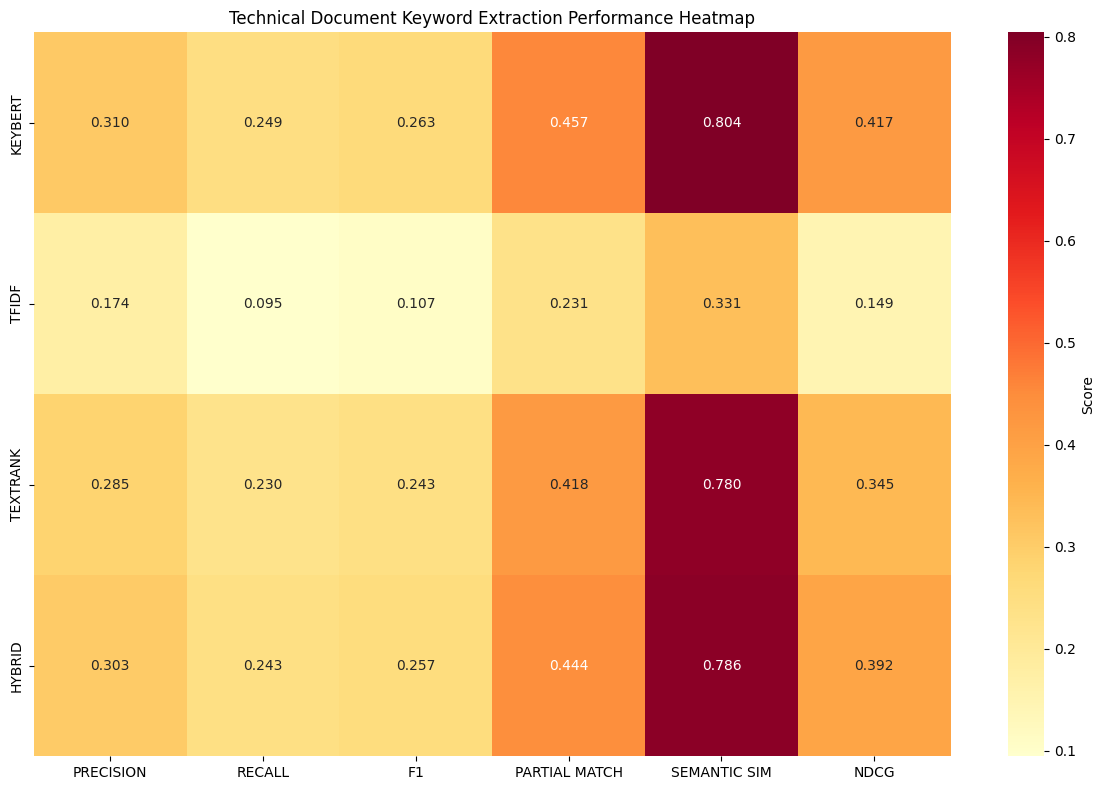

✅ 시각화 완료!

💾 결과 저장 중...
✅ 결과 저장 완료!
  - tech_keyword_extraction_results.csv: 상세 결과
  - tech_keyword_extraction_summary.json: 통계 요약

📋 종합 보고서 생성 중...
기술 문서 키워드 추출 모델 비교 평가 보고서
데이터셋: ecosystems/keywords
평가 일시: 2025-05-25 18:22:58
평가 샘플 수: 100
언어: 영어
도메인: 기술 문서
생태계 분포: {'npm': 56, 'nuget': 10, 'maven': 9, 'packagist': 8, 'pypi': 8}

📊 성능 요약 (평균 ± 표준편차)
------------------------------------------------------------

PRECISION@5:
     KEYBERT: 0.3098 ± 0.2586
       TFIDF: 0.1740 ± 0.3073
    TEXTRANK: 0.2850 ± 0.2603
      HYBRID: 0.3030 ± 0.2592

RECALL@5:
     KEYBERT: 0.2488 ± 0.2353
       TFIDF: 0.0946 ± 0.1888
    TEXTRANK: 0.2295 ± 0.2306
      HYBRID: 0.2429 ± 0.2344

F1@5:
     KEYBERT: 0.2628 ± 0.2267
       TFIDF: 0.1070 ± 0.1914
    TEXTRANK: 0.2428 ± 0.2283
      HYBRID: 0.2573 ± 0.2275

PARTIAL MATCH@5:
     KEYBERT: 0.4572 ± 0.2840
       TFIDF: 0.2310 ± 0.3531
    TEXTRANK: 0.4183 ± 0.2792
      HYBRID: 0.4443 ± 0.2770

SEMANTIC SIM@5:
     KEYBERT: 0.8043 ± 0.3380
       TFI

In [31]:
evaluator = TechKeywordExtractorComparison(num_samples=100, random_seed=42)
evaluator.run_tech_evaluation()

In [20]:
dataset = load_dataset("ecosystems/keywords")
dataset

README.md:   0%|          | 0.00/169 [00:00<?, ?B/s]

keywords.csv:   0%|          | 0.00/781M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2891575 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'ecosystem', 'name', 'description', 'keywords'],
        num_rows: 2891575
    })
})